In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=2048 * 8)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=500)
parser.add_argument('--batch-size', type=int, default=128)
parser.add_argument('--test-batch-size', type=int, default=4096)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=0.5)
parser.add_argument('--rho-incr-iter', type=int, default=4)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=6e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=30)

dataset_name = ["double_net/1x2-pv.csv"]
args = parser.parse_args(args=[])
args

Namespace(batch_size=128, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=500, num_examples=524288, random_seed=0, rgt_start=0, rho=0.5, rho_incr_amount=1.0, rho_incr_iter=4, sinkhorn_epsilon=0.06, sinkhorn_rounds=30, test_batch_size=4096, test_iter=5, test_misreport_iter=2000, test_num_examples=16384)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, clamp_op, args.sinkhorn_epsilon, args.sinkhorn_rounds
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=16384 * 8, shuffle=True)

pavlov U[2,3] Auction


In [6]:
%%time
train_loop(model, train_loader, args, device=device)

  0%|          | 1/500 [00:03<29:56,  3.60s/it]

{'regret_max': 0.46653568744659424, 'regret_mean': 0.12130290269851685, 'payment': 1.011296272277832}


  0%|          | 2/500 [00:07<29:48,  3.59s/it]

{'regret_max': 0.12707901000976562, 'regret_mean': 0.0266007948666811, 'payment': 1.2127814292907715}


  1%|          | 3/500 [00:10<29:41,  3.59s/it]

{'regret_max': 0.1734997034072876, 'regret_mean': 0.04264165833592415, 'payment': 1.5360920429229736}


  1%|          | 4/500 [00:14<29:36,  3.58s/it]

{'regret_max': 0.1697903871536255, 'regret_mean': 0.03351816534996033, 'payment': 1.6481949090957642}


  1%|          | 5/500 [00:17<29:32,  3.58s/it]

{'regret_max': 0.17186498641967773, 'regret_mean': 0.03949257731437683, 'payment': 1.7683436870574951}


  1%|          | 6/500 [00:21<29:29,  3.58s/it]

{'regret_max': 0.19968748092651367, 'regret_mean': 0.04317410662770271, 'payment': 1.8501694202423096}


  1%|▏         | 7/500 [00:25<29:27,  3.59s/it]

{'regret_max': 0.2115952968597412, 'regret_mean': 0.041855908930301666, 'payment': 1.9292376041412354}


  2%|▏         | 8/500 [00:28<29:25,  3.59s/it]

{'regret_max': 0.25221455097198486, 'regret_mean': 0.05103828012943268, 'payment': 2.012587070465088}


  2%|▏         | 9/500 [00:32<29:22,  3.59s/it]

{'regret_max': 0.23775053024291992, 'regret_mean': 0.048340387642383575, 'payment': 2.0207810401916504}


  2%|▏         | 10/500 [00:35<29:20,  3.59s/it]

{'regret_max': 0.2493804693222046, 'regret_mean': 0.055421359837055206, 'payment': 2.0658671855926514}


  2%|▏         | 11/500 [00:39<29:17,  3.59s/it]

{'regret_max': 0.20563256740570068, 'regret_mean': 0.04535260796546936, 'payment': 2.0467748641967773}


  2%|▏         | 12/500 [00:43<29:14,  3.60s/it]

{'regret_max': 0.21492552757263184, 'regret_mean': 0.04589536786079407, 'payment': 2.0687270164489746}


  3%|▎         | 13/500 [00:46<29:12,  3.60s/it]

{'regret_max': 0.1673276424407959, 'regret_mean': 0.036848220974206924, 'payment': 2.036951780319214}


  3%|▎         | 14/500 [00:50<29:09,  3.60s/it]

{'regret_max': 0.1491847038269043, 'regret_mean': 0.033213283866643906, 'payment': 2.029752731323242}


  3%|▎         | 15/500 [00:53<29:06,  3.60s/it]

{'regret_max': 0.1178731918334961, 'regret_mean': 0.025827854871749878, 'payment': 1.9983367919921875}


  3%|▎         | 16/500 [00:57<29:04,  3.60s/it]

{'regret_max': 0.10620546340942383, 'regret_mean': 0.025220543146133423, 'payment': 2.0074727535247803}


  3%|▎         | 17/500 [01:01<29:02,  3.61s/it]

{'regret_max': 0.08178627490997314, 'regret_mean': 0.023517413064837456, 'payment': 2.006608009338379}


  4%|▎         | 18/500 [01:04<29:00,  3.61s/it]

{'regret_max': 0.06833755970001221, 'regret_mean': 0.02178693562746048, 'payment': 2.003824472427368}


  4%|▍         | 19/500 [01:08<28:57,  3.61s/it]

{'regret_max': 0.061408162117004395, 'regret_mean': 0.021574867889285088, 'payment': 2.0081844329833984}


  4%|▍         | 20/500 [01:11<28:55,  3.62s/it]

{'regret_max': 0.05402112007141113, 'regret_mean': 0.021389011293649673, 'payment': 2.0063388347625732}


  4%|▍         | 21/500 [01:15<28:52,  3.62s/it]

{'regret_max': 0.07904434204101562, 'regret_mean': 0.02576413005590439, 'payment': 2.005509376525879}


  4%|▍         | 22/500 [01:19<28:49,  3.62s/it]

{'regret_max': 0.06324565410614014, 'regret_mean': 0.023499034345149994, 'payment': 2.0244736671447754}


  5%|▍         | 23/500 [01:22<28:48,  3.62s/it]

{'regret_max': 0.06763923168182373, 'regret_mean': 0.01777970977127552, 'payment': 1.9939326047897339}


  5%|▍         | 24/500 [01:26<28:46,  3.63s/it]

{'regret_max': 0.07903134822845459, 'regret_mean': 0.024184182286262512, 'payment': 2.016042709350586}


  5%|▌         | 25/500 [01:30<28:43,  3.63s/it]

tensor([[5.9277]], device='cuda:0')
{'regret_max': 0.07283174991607666, 'regret_mean': 0.02302299253642559, 'payment': 2.0245814323425293}


  5%|▌         | 26/500 [01:33<28:40,  3.63s/it]

{'regret_max': 0.06852328777313232, 'regret_mean': 0.01792396605014801, 'payment': 1.9897993803024292}


  5%|▌         | 27/500 [01:37<28:37,  3.63s/it]

{'regret_max': 0.13972151279449463, 'regret_mean': 0.03297272324562073, 'payment': 1.9979112148284912}


  6%|▌         | 28/500 [01:41<28:34,  3.63s/it]

{'regret_max': 0.07832634449005127, 'regret_mean': 0.01953655481338501, 'payment': 2.0135319232940674}


  6%|▌         | 29/500 [01:44<28:31,  3.63s/it]

{'regret_max': 0.06554150581359863, 'regret_mean': 0.013337272219359875, 'payment': 1.9907749891281128}


  6%|▌         | 30/500 [01:48<28:27,  3.63s/it]

{'regret_max': 0.05926096439361572, 'regret_mean': 0.019468411803245544, 'payment': 2.043431520462036}


  6%|▌         | 31/500 [01:51<28:24,  3.63s/it]

{'regret_max': 0.05189371109008789, 'regret_mean': 0.013071727007627487, 'payment': 2.013101100921631}


  6%|▋         | 32/500 [01:55<28:20,  3.63s/it]

{'regret_max': 0.0493922233581543, 'regret_mean': 0.016496773809194565, 'payment': 2.0447161197662354}


  7%|▋         | 33/500 [01:59<28:17,  3.63s/it]

{'regret_max': 0.046684980392456055, 'regret_mean': 0.015394414775073528, 'payment': 2.0401451587677}


  7%|▋         | 34/500 [02:02<28:13,  3.63s/it]

{'regret_max': 0.04760146141052246, 'regret_mean': 0.01532827876508236, 'payment': 2.0480098724365234}


  7%|▋         | 35/500 [02:06<28:10,  3.63s/it]

{'regret_max': 0.04375433921813965, 'regret_mean': 0.014161325059831142, 'payment': 2.0436344146728516}


  7%|▋         | 36/500 [02:10<28:11,  3.65s/it]

{'regret_max': 0.04273056983947754, 'regret_mean': 0.016404828056693077, 'payment': 2.0605459213256836}


  7%|▋         | 37/500 [02:13<28:09,  3.65s/it]

{'regret_max': 0.040456533432006836, 'regret_mean': 0.014227757230401039, 'payment': 2.050163984298706}


  8%|▊         | 38/500 [02:17<28:06,  3.65s/it]

{'regret_max': 0.042038917541503906, 'regret_mean': 0.016348086297512054, 'payment': 2.066352128982544}


  8%|▊         | 39/500 [02:21<28:02,  3.65s/it]

{'regret_max': 0.03859663009643555, 'regret_mean': 0.014453794807195663, 'payment': 2.057533025741577}


  8%|▊         | 40/500 [02:24<27:59,  3.65s/it]

{'regret_max': 0.04142475128173828, 'regret_mean': 0.016040585935115814, 'payment': 2.0697145462036133}


  8%|▊         | 41/500 [02:28<27:56,  3.65s/it]

{'regret_max': 0.04119396209716797, 'regret_mean': 0.014996016398072243, 'payment': 2.064471960067749}


  8%|▊         | 42/500 [02:32<27:52,  3.65s/it]

{'regret_max': 0.03745532035827637, 'regret_mean': 0.014962156303226948, 'payment': 2.0681121349334717}


  9%|▊         | 43/500 [02:35<27:48,  3.65s/it]

{'regret_max': 0.039697885513305664, 'regret_mean': 0.0149496765807271, 'payment': 2.0687713623046875}


  9%|▉         | 44/500 [02:39<27:45,  3.65s/it]

{'regret_max': 0.03823208808898926, 'regret_mean': 0.01491633616387844, 'payment': 2.070849657058716}


  9%|▉         | 45/500 [02:42<27:42,  3.65s/it]

{'regret_max': 0.04113888740539551, 'regret_mean': 0.01459546945989132, 'payment': 2.067744731903076}


  9%|▉         | 46/500 [02:46<27:38,  3.65s/it]

{'regret_max': 0.2264816164970398, 'regret_mean': 0.06636913865804672, 'payment': 1.9413092136383057}


  9%|▉         | 47/500 [02:50<27:35,  3.65s/it]

{'regret_max': 0.3122657537460327, 'regret_mean': 0.06447204947471619, 'payment': 1.4895249605178833}


 10%|▉         | 48/500 [02:53<27:31,  3.65s/it]

{'regret_max': 0.3566814661026001, 'regret_mean': 0.04629954323172569, 'payment': 1.146729826927185}


 10%|▉         | 49/500 [02:57<27:28,  3.66s/it]

{'regret_max': 0.364443302154541, 'regret_mean': 0.055206384509801865, 'payment': 1.3765230178833008}


 10%|█         | 50/500 [03:01<27:25,  3.66s/it]

tensor([[9.8504]], device='cuda:0')
{'regret_max': 0.2935572862625122, 'regret_mean': 0.06083928421139717, 'payment': 1.6320703029632568}


 10%|█         | 51/500 [03:04<27:21,  3.66s/it]

{'regret_max': 0.1949312686920166, 'regret_mean': 0.01782207563519478, 'payment': 1.3729422092437744}


 10%|█         | 52/500 [03:08<27:18,  3.66s/it]

{'regret_max': 0.2142850160598755, 'regret_mean': 0.04336416721343994, 'payment': 1.8249250650405884}


 11%|█         | 53/500 [03:12<27:14,  3.66s/it]

{'regret_max': 0.14677584171295166, 'regret_mean': 0.039643991738557816, 'payment': 1.8362293243408203}


 11%|█         | 54/500 [03:15<27:10,  3.66s/it]

{'regret_max': 0.08659076690673828, 'regret_mean': 0.019733630120754242, 'payment': 1.8334405422210693}


 11%|█         | 55/500 [03:19<27:07,  3.66s/it]

{'regret_max': 0.07481884956359863, 'regret_mean': 0.01307807769626379, 'payment': 1.8945133686065674}


 11%|█         | 56/500 [03:23<27:03,  3.66s/it]

{'regret_max': 0.10727667808532715, 'regret_mean': 0.03523862734436989, 'payment': 2.0109031200408936}


 11%|█▏        | 57/500 [03:26<26:59,  3.66s/it]

{'regret_max': 0.06290662288665771, 'regret_mean': 0.01910373568534851, 'payment': 1.9652351140975952}


 12%|█▏        | 58/500 [03:30<26:56,  3.66s/it]

{'regret_max': 0.08894515037536621, 'regret_mean': 0.016306724399328232, 'payment': 1.8986533880233765}


 12%|█▏        | 59/500 [03:34<26:53,  3.66s/it]

{'regret_max': 0.07141566276550293, 'regret_mean': 0.0161181278526783, 'payment': 1.9387214183807373}


 12%|█▏        | 60/500 [03:37<26:49,  3.66s/it]

{'regret_max': 0.042598605155944824, 'regret_mean': 0.013151707127690315, 'payment': 1.9957243204116821}


 12%|█▏        | 61/500 [03:41<26:46,  3.66s/it]

{'regret_max': 0.04996991157531738, 'regret_mean': 0.012457748875021935, 'payment': 2.0016884803771973}


 12%|█▏        | 62/500 [03:45<26:42,  3.66s/it]

{'regret_max': 0.03688955307006836, 'regret_mean': 0.009961619973182678, 'payment': 1.990319848060608}


 13%|█▎        | 63/500 [03:48<26:38,  3.66s/it]

{'regret_max': 0.03274059295654297, 'regret_mean': 0.009289762005209923, 'payment': 2.004786491394043}


 13%|█▎        | 64/500 [03:52<26:34,  3.66s/it]

{'regret_max': 0.02977728843688965, 'regret_mean': 0.008635668084025383, 'payment': 2.009350061416626}


 13%|█▎        | 65/500 [03:56<26:31,  3.66s/it]

{'regret_max': 0.028109431266784668, 'regret_mean': 0.007845597341656685, 'payment': 2.002645254135132}


 13%|█▎        | 66/500 [03:59<26:27,  3.66s/it]

{'regret_max': 0.025777101516723633, 'regret_mean': 0.00752829946577549, 'payment': 2.003389358520508}


 13%|█▎        | 67/500 [04:03<26:23,  3.66s/it]

{'regret_max': 0.022914886474609375, 'regret_mean': 0.007903221994638443, 'payment': 2.013690948486328}


 14%|█▎        | 68/500 [04:07<26:20,  3.66s/it]

{'regret_max': 0.023308515548706055, 'regret_mean': 0.008067401126027107, 'payment': 2.018796920776367}


 14%|█▍        | 69/500 [04:10<26:22,  3.67s/it]

{'regret_max': 0.02203226089477539, 'regret_mean': 0.0076138935983181, 'payment': 2.015519857406616}


 14%|█▍        | 70/500 [04:14<26:17,  3.67s/it]

{'regret_max': 0.02243971824645996, 'regret_mean': 0.00757326977327466, 'payment': 2.017000436782837}


 14%|█▍        | 71/500 [04:18<26:11,  3.66s/it]

{'regret_max': 0.0224153995513916, 'regret_mean': 0.007662057876586914, 'payment': 2.0194387435913086}


 14%|█▍        | 72/500 [04:21<26:07,  3.66s/it]

{'regret_max': 0.021613121032714844, 'regret_mean': 0.007380573078989983, 'payment': 2.017723798751831}


 15%|█▍        | 73/500 [04:25<26:03,  3.66s/it]

{'regret_max': 0.022225618362426758, 'regret_mean': 0.007340415380895138, 'payment': 2.019463539123535}


 15%|█▍        | 74/500 [04:29<25:59,  3.66s/it]

{'regret_max': 0.022465944290161133, 'regret_mean': 0.007481486536562443, 'payment': 2.0228400230407715}


 15%|█▌        | 75/500 [04:32<25:55,  3.66s/it]

tensor([[10.3994]], device='cuda:0')
{'regret_max': 0.02289295196533203, 'regret_mean': 0.007266029249876738, 'payment': 2.0219287872314453}


 15%|█▌        | 76/500 [04:36<25:50,  3.66s/it]

{'regret_max': 0.02393031120300293, 'regret_mean': 0.007090788800269365, 'payment': 2.021186113357544}


 15%|█▌        | 77/500 [04:40<25:47,  3.66s/it]

{'regret_max': 0.02373790740966797, 'regret_mean': 0.006966316606849432, 'payment': 2.021003484725952}


 16%|█▌        | 78/500 [04:43<25:43,  3.66s/it]

{'regret_max': 0.023400068283081055, 'regret_mean': 0.006917864549905062, 'payment': 2.0219573974609375}


 16%|█▌        | 79/500 [04:47<25:39,  3.66s/it]

{'regret_max': 0.023825645446777344, 'regret_mean': 0.006852334830909967, 'payment': 2.0228357315063477}


 16%|█▌        | 80/500 [04:51<25:35,  3.66s/it]

{'regret_max': 0.024305343627929688, 'regret_mean': 0.006792305037379265, 'payment': 2.0237202644348145}


 16%|█▌        | 81/500 [04:54<25:32,  3.66s/it]

{'regret_max': 0.024367332458496094, 'regret_mean': 0.0067945923656225204, 'payment': 2.025261402130127}


 16%|█▋        | 82/500 [04:58<25:28,  3.66s/it]

{'regret_max': 0.024489402770996094, 'regret_mean': 0.006698632147163153, 'payment': 2.0255990028381348}


 17%|█▋        | 83/500 [05:02<25:25,  3.66s/it]

{'regret_max': 0.024546384811401367, 'regret_mean': 0.006634245626628399, 'payment': 2.026434898376465}


 17%|█▋        | 84/500 [05:05<25:21,  3.66s/it]

{'regret_max': 0.02453923225402832, 'regret_mean': 0.006595443934202194, 'payment': 2.0275909900665283}


 17%|█▋        | 85/500 [05:09<25:17,  3.66s/it]

{'regret_max': 0.02461409568786621, 'regret_mean': 0.006547393277287483, 'payment': 2.028639793395996}


 17%|█▋        | 86/500 [05:12<25:14,  3.66s/it]

{'regret_max': 0.025425434112548828, 'regret_mean': 0.00648778211325407, 'payment': 2.029644012451172}


 17%|█▋        | 87/500 [05:16<25:10,  3.66s/it]

{'regret_max': 0.02523064613342285, 'regret_mean': 0.006472786422818899, 'payment': 2.031069755554199}


 18%|█▊        | 88/500 [05:20<25:06,  3.66s/it]

{'regret_max': 0.025246858596801758, 'regret_mean': 0.0064371200278401375, 'payment': 2.032308340072632}


 18%|█▊        | 89/500 [05:23<25:03,  3.66s/it]

{'regret_max': 0.025689125061035156, 'regret_mean': 0.006363151129335165, 'payment': 2.0332064628601074}


 18%|█▊        | 90/500 [05:27<24:59,  3.66s/it]

{'regret_max': 0.02567744255065918, 'regret_mean': 0.006357708480209112, 'payment': 2.0347912311553955}


 18%|█▊        | 91/500 [05:31<24:56,  3.66s/it]

{'regret_max': 0.025974273681640625, 'regret_mean': 0.006375123746693134, 'payment': 2.036757469177246}


 18%|█▊        | 92/500 [05:34<24:52,  3.66s/it]

{'regret_max': 0.028020858764648438, 'regret_mean': 0.0066186049953103065, 'payment': 2.0386276245117188}


 19%|█▊        | 93/500 [05:38<24:48,  3.66s/it]

{'regret_max': 0.030937671661376953, 'regret_mean': 0.007253187708556652, 'payment': 2.0372235774993896}


 19%|█▉        | 94/500 [05:42<24:44,  3.66s/it]

{'regret_max': 0.029550790786743164, 'regret_mean': 0.006205524783581495, 'payment': 2.0379178524017334}


 19%|█▉        | 95/500 [05:45<24:41,  3.66s/it]

{'regret_max': 0.032553911209106445, 'regret_mean': 0.007579300086945295, 'payment': 2.039698839187622}


 19%|█▉        | 96/500 [05:49<24:37,  3.66s/it]

{'regret_max': 0.03191423416137695, 'regret_mean': 0.007740174885839224, 'payment': 2.0468575954437256}


 19%|█▉        | 97/500 [05:53<24:34,  3.66s/it]

{'regret_max': 0.036394357681274414, 'regret_mean': 0.007336643524467945, 'payment': 2.0284605026245117}


 20%|█▉        | 98/500 [05:56<24:30,  3.66s/it]

{'regret_max': 0.0343174934387207, 'regret_mean': 0.00814748089760542, 'payment': 2.0475080013275146}


 20%|█▉        | 99/500 [06:00<24:26,  3.66s/it]

{'regret_max': 0.02733016014099121, 'regret_mean': 0.006157752592116594, 'payment': 2.0447773933410645}


 20%|██        | 100/500 [06:04<24:23,  3.66s/it]

tensor([[11.3976]], device='cuda:0')
{'regret_max': 0.03173184394836426, 'regret_mean': 0.0074782404117286205, 'payment': 2.0492706298828125}


 20%|██        | 101/500 [06:07<24:19,  3.66s/it]

{'regret_max': 0.029741764068603516, 'regret_mean': 0.005637183785438538, 'payment': 2.0365073680877686}


 20%|██        | 102/500 [06:11<24:24,  3.68s/it]

{'regret_max': 0.043027400970458984, 'regret_mean': 0.010223908349871635, 'payment': 2.038559913635254}


 21%|██        | 103/500 [06:15<24:18,  3.67s/it]

{'regret_max': 0.04211544990539551, 'regret_mean': 0.008611496537923813, 'payment': 2.0330252647399902}


 21%|██        | 104/500 [06:18<24:13,  3.67s/it]

{'regret_max': 0.04160594940185547, 'regret_mean': 0.009181099012494087, 'payment': 2.0425291061401367}


 21%|██        | 105/500 [06:22<24:08,  3.67s/it]

{'regret_max': 0.06100893020629883, 'regret_mean': 0.01068071462213993, 'payment': 2.00889253616333}


 21%|██        | 106/500 [06:26<24:04,  3.67s/it]

{'regret_max': 0.04745602607727051, 'regret_mean': 0.013665209524333477, 'payment': 2.0419363975524902}


 21%|██▏       | 107/500 [06:29<24:00,  3.66s/it]

{'regret_max': 0.046765804290771484, 'regret_mean': 0.006172227207571268, 'payment': 2.0246987342834473}


 22%|██▏       | 108/500 [06:33<23:58,  3.67s/it]

{'regret_max': 0.04124808311462402, 'regret_mean': 0.0100624468177557, 'payment': 2.0520682334899902}


 22%|██▏       | 109/500 [06:37<24:00,  3.68s/it]

{'regret_max': 0.04549384117126465, 'regret_mean': 0.007967174984514713, 'payment': 2.0264532566070557}


 22%|██▏       | 110/500 [06:40<23:57,  3.69s/it]

{'regret_max': 0.04170989990234375, 'regret_mean': 0.009179018437862396, 'payment': 2.0550708770751953}


 22%|██▏       | 111/500 [06:44<23:51,  3.68s/it]

{'regret_max': 0.03500556945800781, 'regret_mean': 0.005482773762196302, 'payment': 2.0381689071655273}


 22%|██▏       | 112/500 [06:48<23:46,  3.68s/it]

{'regret_max': 0.03245067596435547, 'regret_mean': 0.006559375673532486, 'payment': 2.0558981895446777}


 23%|██▎       | 113/500 [06:51<23:42,  3.68s/it]

{'regret_max': 0.02562260627746582, 'regret_mean': 0.005134806968271732, 'payment': 2.051424503326416}


 23%|██▎       | 114/500 [06:55<23:39,  3.68s/it]

{'regret_max': 0.027618885040283203, 'regret_mean': 0.005527915433049202, 'payment': 2.055346965789795}


 23%|██▎       | 115/500 [06:59<23:34,  3.67s/it]

{'regret_max': 0.023946285247802734, 'regret_mean': 0.005342976190149784, 'payment': 2.0548524856567383}


 23%|██▎       | 116/500 [07:03<23:30,  3.67s/it]

{'regret_max': 0.029071331024169922, 'regret_mean': 0.0052368659526109695, 'payment': 2.0533294677734375}


 23%|██▎       | 117/500 [07:06<23:26,  3.67s/it]

{'regret_max': 0.0260775089263916, 'regret_mean': 0.005000950302928686, 'payment': 2.053948163986206}


 24%|██▎       | 118/500 [07:10<23:23,  3.67s/it]

{'regret_max': 0.021346569061279297, 'regret_mean': 0.004774829372763634, 'payment': 2.0556442737579346}


 24%|██▍       | 119/500 [07:14<23:19,  3.67s/it]

{'regret_max': 0.025150537490844727, 'regret_mean': 0.005447794683277607, 'payment': 2.057690382003784}


 24%|██▍       | 120/500 [07:17<23:15,  3.67s/it]

{'regret_max': 0.026378393173217773, 'regret_mean': 0.0048112086951732635, 'payment': 2.0523123741149902}


 24%|██▍       | 121/500 [07:21<23:12,  3.67s/it]

{'regret_max': 0.0200498104095459, 'regret_mean': 0.004545767791569233, 'payment': 2.058051586151123}


 24%|██▍       | 122/500 [07:25<23:08,  3.67s/it]

{'regret_max': 0.02245330810546875, 'regret_mean': 0.00490022636950016, 'payment': 2.059202194213867}


 25%|██▍       | 123/500 [07:28<23:04,  3.67s/it]

{'regret_max': 0.02217245101928711, 'regret_mean': 0.004187968093901873, 'payment': 2.0576555728912354}


 25%|██▍       | 124/500 [07:32<23:00,  3.67s/it]

{'regret_max': 0.02590036392211914, 'regret_mean': 0.0045279525220394135, 'payment': 2.056835889816284}


 25%|██▌       | 125/500 [07:36<22:57,  3.67s/it]

tensor([[12.0748]], device='cuda:0')
{'regret_max': 0.024915456771850586, 'regret_mean': 0.0051618111319839954, 'payment': 2.0646140575408936}


 25%|██▌       | 126/500 [07:39<22:53,  3.67s/it]

{'regret_max': 0.023487329483032227, 'regret_mean': 0.004112564027309418, 'payment': 2.053126573562622}


 25%|██▌       | 127/500 [07:43<22:50,  3.67s/it]

{'regret_max': 0.027493000030517578, 'regret_mean': 0.004583676345646381, 'payment': 2.0567197799682617}


 26%|██▌       | 128/500 [07:47<22:46,  3.67s/it]

{'regret_max': 0.01850104331970215, 'regret_mean': 0.004328910727053881, 'payment': 2.0679125785827637}


 26%|██▌       | 129/500 [07:50<22:43,  3.67s/it]

{'regret_max': 0.025174617767333984, 'regret_mean': 0.004067511297762394, 'payment': 2.0571916103363037}


 26%|██▌       | 130/500 [07:54<22:38,  3.67s/it]

{'regret_max': 0.02207326889038086, 'regret_mean': 0.004102595616132021, 'payment': 2.059454917907715}


 26%|██▌       | 131/500 [07:58<22:34,  3.67s/it]

{'regret_max': 0.019753456115722656, 'regret_mean': 0.004089162219315767, 'payment': 2.062681198120117}


 26%|██▋       | 132/500 [08:01<22:30,  3.67s/it]

{'regret_max': 0.0227358341217041, 'regret_mean': 0.003985627554357052, 'payment': 2.0596556663513184}


 27%|██▋       | 133/500 [08:05<22:26,  3.67s/it]

{'regret_max': 0.022276878356933594, 'regret_mean': 0.004109390079975128, 'payment': 2.060004234313965}


 27%|██▋       | 134/500 [08:09<22:32,  3.69s/it]

{'regret_max': 0.020141124725341797, 'regret_mean': 0.003914159722626209, 'payment': 2.0630884170532227}


 27%|██▋       | 135/500 [08:12<22:25,  3.69s/it]

{'regret_max': 0.020076513290405273, 'regret_mean': 0.003476131707429886, 'payment': 2.063891887664795}


 27%|██▋       | 136/500 [08:16<22:19,  3.68s/it]

{'regret_max': 0.020123720169067383, 'regret_mean': 0.003575660288333893, 'payment': 2.064363956451416}


 27%|██▋       | 137/500 [08:20<22:15,  3.68s/it]

{'regret_max': 0.022676467895507812, 'regret_mean': 0.0041246721521019936, 'payment': 2.062997341156006}


 28%|██▊       | 138/500 [08:23<22:10,  3.67s/it]

{'regret_max': 0.023380756378173828, 'regret_mean': 0.0040892865508794785, 'payment': 2.060995578765869}


 28%|██▊       | 139/500 [08:27<22:05,  3.67s/it]

{'regret_max': 0.0192108154296875, 'regret_mean': 0.0032755034044384956, 'payment': 2.0660324096679688}


 28%|██▊       | 140/500 [08:31<22:01,  3.67s/it]

{'regret_max': 0.0165252685546875, 'regret_mean': 0.003058892209082842, 'payment': 2.070112705230713}


 28%|██▊       | 141/500 [08:34<21:57,  3.67s/it]

{'regret_max': 0.017017841339111328, 'regret_mean': 0.003295592265203595, 'payment': 2.065089225769043}


 28%|██▊       | 142/500 [08:38<21:53,  3.67s/it]

{'regret_max': 0.03208041191101074, 'regret_mean': 0.005202633328735828, 'payment': 2.056877613067627}


 29%|██▊       | 143/500 [08:42<21:49,  3.67s/it]

{'regret_max': 0.02115941047668457, 'regret_mean': 0.003933854401111603, 'payment': 2.0779051780700684}


 29%|██▉       | 144/500 [08:45<21:45,  3.67s/it]

{'regret_max': 0.03489828109741211, 'regret_mean': 0.0038650850765407085, 'payment': 2.0535144805908203}


 29%|██▉       | 145/500 [08:49<21:41,  3.67s/it]

{'regret_max': 0.02720785140991211, 'regret_mean': 0.0047988505102694035, 'payment': 2.081101179122925}


 29%|██▉       | 146/500 [08:53<21:37,  3.67s/it]

{'regret_max': 0.03196215629577637, 'regret_mean': 0.004440464079380035, 'payment': 2.056831121444702}


 29%|██▉       | 147/500 [08:56<21:34,  3.67s/it]

{'regret_max': 0.04479098320007324, 'regret_mean': 0.010462055914103985, 'payment': 2.0727388858795166}


 30%|██▉       | 148/500 [09:00<21:30,  3.67s/it]

{'regret_max': 0.0648493766784668, 'regret_mean': 0.01490835752338171, 'payment': 2.039536952972412}


 30%|██▉       | 149/500 [09:04<21:26,  3.67s/it]

{'regret_max': 0.07080912590026855, 'regret_mean': 0.01811457797884941, 'payment': 2.023021697998047}


 30%|███       | 150/500 [09:07<21:23,  3.67s/it]

tensor([[13.5879]], device='cuda:0')
{'regret_max': 0.11857414245605469, 'regret_mean': 0.02482779324054718, 'payment': 2.0497097969055176}


 30%|███       | 151/500 [09:11<21:19,  3.67s/it]

{'regret_max': 0.07187414169311523, 'regret_mean': 0.017429379746317863, 'payment': 2.077821731567383}


 30%|███       | 152/500 [09:15<21:15,  3.67s/it]

{'regret_max': 0.07178807258605957, 'regret_mean': 0.012995528988540173, 'payment': 2.030895471572876}


 31%|███       | 153/500 [09:18<21:12,  3.67s/it]

{'regret_max': 0.053629398345947266, 'regret_mean': 0.012310411781072617, 'payment': 2.0985143184661865}


 31%|███       | 154/500 [09:22<21:08,  3.67s/it]

{'regret_max': 0.06282830238342285, 'regret_mean': 0.007373682223260403, 'payment': 2.0481278896331787}


 31%|███       | 155/500 [09:26<21:05,  3.67s/it]

{'regret_max': 0.031199932098388672, 'regret_mean': 0.007924599573016167, 'payment': 2.097487449645996}


 31%|███       | 156/500 [09:29<21:01,  3.67s/it]

{'regret_max': 0.04221701622009277, 'regret_mean': 0.004933689720928669, 'payment': 2.070499897003174}


 31%|███▏      | 157/500 [09:33<20:57,  3.67s/it]

{'regret_max': 0.029650449752807617, 'regret_mean': 0.005587482824921608, 'payment': 2.0921037197113037}


 32%|███▏      | 158/500 [09:37<20:54,  3.67s/it]

{'regret_max': 0.024067401885986328, 'regret_mean': 0.004245319403707981, 'payment': 2.0807442665100098}


 32%|███▏      | 159/500 [09:40<20:50,  3.67s/it]

{'regret_max': 0.02092885971069336, 'regret_mean': 0.0031014657579362392, 'payment': 2.067067861557007}


 32%|███▏      | 160/500 [09:44<20:46,  3.67s/it]

{'regret_max': 0.02000713348388672, 'regret_mean': 0.004701131954789162, 'payment': 2.0865848064422607}


 32%|███▏      | 161/500 [09:48<20:42,  3.67s/it]

{'regret_max': 0.03636932373046875, 'regret_mean': 0.004915421828627586, 'payment': 2.0494539737701416}


 32%|███▏      | 162/500 [09:51<20:39,  3.67s/it]

{'regret_max': 0.018187761306762695, 'regret_mean': 0.0048298826441168785, 'payment': 2.077816963195801}


 33%|███▎      | 163/500 [09:55<20:35,  3.67s/it]

{'regret_max': 0.0335545539855957, 'regret_mean': 0.0051297759637236595, 'payment': 2.0816173553466797}


 33%|███▎      | 164/500 [09:59<20:31,  3.67s/it]

{'regret_max': 0.03612089157104492, 'regret_mean': 0.0047255042009055614, 'payment': 2.0695419311523438}


 33%|███▎      | 165/500 [10:02<20:28,  3.67s/it]

{'regret_max': 0.024768352508544922, 'regret_mean': 0.004433452617377043, 'payment': 2.0749003887176514}


 33%|███▎      | 166/500 [10:06<20:24,  3.67s/it]

{'regret_max': 0.02535700798034668, 'regret_mean': 0.004661510698497295, 'payment': 2.0824077129364014}


 33%|███▎      | 167/500 [10:10<20:31,  3.70s/it]

{'regret_max': 0.025587081909179688, 'regret_mean': 0.004689428489655256, 'payment': 2.0735063552856445}


 34%|███▎      | 168/500 [10:13<20:24,  3.69s/it]

{'regret_max': 0.034128665924072266, 'regret_mean': 0.0043244874104857445, 'payment': 2.0718109607696533}


 34%|███▍      | 169/500 [10:17<20:18,  3.68s/it]

{'regret_max': 0.022272586822509766, 'regret_mean': 0.004194493405520916, 'payment': 2.0903069972991943}


 34%|███▍      | 170/500 [10:21<20:13,  3.68s/it]

{'regret_max': 0.020424842834472656, 'regret_mean': 0.004167563281953335, 'payment': 2.0761942863464355}


 34%|███▍      | 171/500 [10:24<20:08,  3.67s/it]

{'regret_max': 0.032790184020996094, 'regret_mean': 0.004260517191141844, 'payment': 2.071533441543579}


 34%|███▍      | 172/500 [10:28<20:04,  3.67s/it]

{'regret_max': 0.02453136444091797, 'regret_mean': 0.0046372669748961926, 'payment': 2.0921216011047363}


 35%|███▍      | 173/500 [10:32<20:00,  3.67s/it]

{'regret_max': 0.020747900009155273, 'regret_mean': 0.0034691179171204567, 'payment': 2.079855442047119}


 35%|███▍      | 174/500 [10:35<19:56,  3.67s/it]

{'regret_max': 0.02524113655090332, 'regret_mean': 0.0038361218757927418, 'payment': 2.078108310699463}


 35%|███▌      | 175/500 [10:39<19:52,  3.67s/it]

tensor([[14.6947]], device='cuda:0')
{'regret_max': 0.027118206024169922, 'regret_mean': 0.004862098954617977, 'payment': 2.093926429748535}


 35%|███▌      | 176/500 [10:43<19:48,  3.67s/it]

{'regret_max': 0.020876646041870117, 'regret_mean': 0.003376637352630496, 'payment': 2.082754611968994}


 35%|███▌      | 177/500 [10:46<19:44,  3.67s/it]

{'regret_max': 0.022282838821411133, 'regret_mean': 0.003918648697435856, 'payment': 2.0802536010742188}


 36%|███▌      | 178/500 [10:50<19:40,  3.67s/it]

{'regret_max': 0.0298309326171875, 'regret_mean': 0.0053458428010344505, 'payment': 2.091597318649292}


 36%|███▌      | 179/500 [10:54<19:37,  3.67s/it]

{'regret_max': 0.022009611129760742, 'regret_mean': 0.0033057404216378927, 'payment': 2.0825910568237305}


 36%|███▌      | 180/500 [10:57<19:33,  3.67s/it]

{'regret_max': 0.0194244384765625, 'regret_mean': 0.0033901173155754805, 'payment': 2.0855605602264404}


 36%|███▌      | 181/500 [11:01<19:29,  3.67s/it]

{'regret_max': 0.022930622100830078, 'regret_mean': 0.0048670582473278046, 'payment': 2.0976877212524414}


 36%|███▋      | 182/500 [11:05<19:25,  3.67s/it]

{'regret_max': 0.0219423770904541, 'regret_mean': 0.003359453286975622, 'payment': 2.0847678184509277}


 37%|███▋      | 183/500 [11:08<19:22,  3.67s/it]

{'regret_max': 0.017437219619750977, 'regret_mean': 0.0032402975484728813, 'payment': 2.089252471923828}


 37%|███▋      | 184/500 [11:12<19:18,  3.67s/it]

{'regret_max': 0.019621849060058594, 'regret_mean': 0.004309609532356262, 'payment': 2.102598190307617}


 37%|███▋      | 185/500 [11:16<19:14,  3.67s/it]

{'regret_max': 0.01810145378112793, 'regret_mean': 0.0032012807205319405, 'payment': 2.0894875526428223}


 37%|███▋      | 186/500 [11:19<19:11,  3.67s/it]

{'regret_max': 0.016899824142456055, 'regret_mean': 0.003079775720834732, 'payment': 2.0928139686584473}


 37%|███▋      | 187/500 [11:23<19:07,  3.67s/it]

{'regret_max': 0.017184972763061523, 'regret_mean': 0.004270822741091251, 'payment': 2.1073293685913086}


 38%|███▊      | 188/500 [11:27<19:03,  3.67s/it]

{'regret_max': 0.015820980072021484, 'regret_mean': 0.0031189369037747383, 'payment': 2.092376947402954}


 38%|███▊      | 189/500 [11:30<19:00,  3.67s/it]

{'regret_max': 0.017358779907226562, 'regret_mean': 0.0029667778871953487, 'payment': 2.0958518981933594}


 38%|███▊      | 190/500 [11:34<18:56,  3.67s/it]

{'regret_max': 0.01728534698486328, 'regret_mean': 0.004232126288115978, 'payment': 2.1071722507476807}


 38%|███▊      | 191/500 [11:38<18:52,  3.67s/it]

{'regret_max': 0.01523900032043457, 'regret_mean': 0.0032422777730971575, 'payment': 2.0963988304138184}


 38%|███▊      | 192/500 [11:41<18:48,  3.67s/it]

{'regret_max': 0.017404556274414062, 'regret_mean': 0.003065861528739333, 'payment': 2.1007626056671143}


 39%|███▊      | 193/500 [11:45<18:45,  3.67s/it]

{'regret_max': 0.01631617546081543, 'regret_mean': 0.004021844826638699, 'payment': 2.1061484813690186}


 39%|███▉      | 194/500 [11:49<18:42,  3.67s/it]

{'regret_max': 0.015563011169433594, 'regret_mean': 0.003233614843338728, 'payment': 2.1009469032287598}


 39%|███▉      | 195/500 [11:52<18:38,  3.67s/it]

{'regret_max': 0.015172004699707031, 'regret_mean': 0.0030633429996669292, 'payment': 2.102871894836426}


 39%|███▉      | 196/500 [11:56<18:34,  3.67s/it]

{'regret_max': 0.01552438735961914, 'regret_mean': 0.003972257021814585, 'payment': 2.1089916229248047}


 39%|███▉      | 197/500 [12:00<18:31,  3.67s/it]

{'regret_max': 0.015258312225341797, 'regret_mean': 0.0032586713787168264, 'payment': 2.1025030612945557}


 40%|███▉      | 198/500 [12:03<18:27,  3.67s/it]

{'regret_max': 0.014636039733886719, 'regret_mean': 0.003073078580200672, 'payment': 2.104487419128418}


 40%|███▉      | 199/500 [12:07<18:23,  3.67s/it]

{'regret_max': 0.015400409698486328, 'regret_mean': 0.0039893705397844315, 'payment': 2.1136791706085205}


 40%|████      | 200/500 [12:11<18:31,  3.71s/it]

tensor([[15.2191]], device='cuda:0')
{'regret_max': 0.013489007949829102, 'regret_mean': 0.0030849159229546785, 'payment': 2.105165481567383}


 40%|████      | 201/500 [12:15<18:24,  3.69s/it]

{'regret_max': 0.014010190963745117, 'regret_mean': 0.0029663541354238987, 'payment': 2.1075520515441895}


 40%|████      | 202/500 [12:18<18:18,  3.69s/it]

{'regret_max': 0.01540684700012207, 'regret_mean': 0.0038889471907168627, 'payment': 2.1167659759521484}


 41%|████      | 203/500 [12:22<18:12,  3.68s/it]

{'regret_max': 0.01608562469482422, 'regret_mean': 0.0035978672094643116, 'payment': 2.1046128273010254}


 41%|████      | 204/500 [12:26<18:08,  3.68s/it]

{'regret_max': 0.018163204193115234, 'regret_mean': 0.0033260188065469265, 'payment': 2.107818603515625}


 41%|████      | 205/500 [12:29<18:03,  3.67s/it]

{'regret_max': 0.013802647590637207, 'regret_mean': 0.0031943959183990955, 'payment': 2.1206412315368652}


 41%|████      | 206/500 [12:33<17:59,  3.67s/it]

{'regret_max': 0.01174318790435791, 'regret_mean': 0.002550792880356312, 'payment': 2.119739055633545}


 41%|████▏     | 207/500 [12:37<17:55,  3.67s/it]

{'regret_max': 0.010533332824707031, 'regret_mean': 0.002232828177511692, 'payment': 2.115330934524536}


 42%|████▏     | 208/500 [12:40<17:52,  3.67s/it]

{'regret_max': 0.011121153831481934, 'regret_mean': 0.0022517479956150055, 'payment': 2.11722731590271}


 42%|████▏     | 209/500 [12:44<17:48,  3.67s/it]

{'regret_max': 0.010536789894104004, 'regret_mean': 0.0020761601626873016, 'payment': 2.1181535720825195}


 42%|████▏     | 210/500 [12:48<17:44,  3.67s/it]

{'regret_max': 0.010796427726745605, 'regret_mean': 0.0022820523008704185, 'payment': 2.1221795082092285}


 42%|████▏     | 211/500 [12:51<17:40,  3.67s/it]

{'regret_max': 0.01140749454498291, 'regret_mean': 0.002146519720554352, 'payment': 2.1205735206604004}


 42%|████▏     | 212/500 [12:55<17:36,  3.67s/it]

{'regret_max': 0.01033163070678711, 'regret_mean': 0.0020831201691180468, 'payment': 2.119955062866211}


 43%|████▎     | 213/500 [12:59<17:32,  3.67s/it]

{'regret_max': 0.010947823524475098, 'regret_mean': 0.002148672239854932, 'payment': 2.1215195655822754}


 43%|████▎     | 214/500 [13:02<17:28,  3.67s/it]

{'regret_max': 0.010796308517456055, 'regret_mean': 0.0020972162019461393, 'payment': 2.121572494506836}


 43%|████▎     | 215/500 [13:06<17:24,  3.67s/it]

{'regret_max': 0.010755658149719238, 'regret_mean': 0.0021649040281772614, 'payment': 2.1232290267944336}


 43%|████▎     | 216/500 [13:10<17:21,  3.67s/it]

{'regret_max': 0.010586380958557129, 'regret_mean': 0.0020943456329405308, 'payment': 2.122788667678833}


 43%|████▎     | 217/500 [13:13<17:17,  3.67s/it]

{'regret_max': 0.01089465618133545, 'regret_mean': 0.0021154095884412527, 'payment': 2.123342990875244}


 44%|████▎     | 218/500 [13:17<17:14,  3.67s/it]

{'regret_max': 0.01078951358795166, 'regret_mean': 0.0021008295007050037, 'payment': 2.1236042976379395}


 44%|████▍     | 219/500 [13:21<17:10,  3.67s/it]

{'regret_max': 0.010854005813598633, 'regret_mean': 0.0021074931137263775, 'payment': 2.124218463897705}


 44%|████▍     | 220/500 [13:24<17:06,  3.67s/it]

{'regret_max': 0.010977864265441895, 'regret_mean': 0.0021340157836675644, 'payment': 2.1248903274536133}


 44%|████▍     | 221/500 [13:28<17:03,  3.67s/it]

{'regret_max': 0.010798096656799316, 'regret_mean': 0.0020986851304769516, 'payment': 2.1246657371520996}


 44%|████▍     | 222/500 [13:32<16:59,  3.67s/it]

{'regret_max': 0.011007070541381836, 'regret_mean': 0.0021059559658169746, 'payment': 2.125244140625}


 45%|████▍     | 223/500 [13:35<16:55,  3.67s/it]

{'regret_max': 0.010942339897155762, 'regret_mean': 0.00212503457441926, 'payment': 2.1258678436279297}


 45%|████▍     | 224/500 [13:39<16:52,  3.67s/it]

{'regret_max': 0.010943770408630371, 'regret_mean': 0.0021035068202763796, 'payment': 2.125864028930664}


 45%|████▌     | 225/500 [13:43<16:48,  3.67s/it]

tensor([[15.6917]], device='cuda:0')
{'regret_max': 0.010918855667114258, 'regret_mean': 0.002101354766637087, 'payment': 2.126204490661621}


 45%|████▌     | 226/500 [13:46<16:44,  3.67s/it]

{'regret_max': 0.01107168197631836, 'regret_mean': 0.00206013023853302, 'payment': 2.125808000564575}


 45%|████▌     | 227/500 [13:50<16:41,  3.67s/it]

{'regret_max': 0.011007189750671387, 'regret_mean': 0.0020647631026804447, 'payment': 2.126331329345703}


 46%|████▌     | 228/500 [13:54<16:37,  3.67s/it]

{'regret_max': 0.010901808738708496, 'regret_mean': 0.0020561900455504656, 'payment': 2.1265716552734375}


 46%|████▌     | 229/500 [13:57<16:33,  3.67s/it]

{'regret_max': 0.010958313941955566, 'regret_mean': 0.002041769679635763, 'payment': 2.12668514251709}


 46%|████▌     | 230/500 [14:01<16:29,  3.67s/it]

{'regret_max': 0.010899782180786133, 'regret_mean': 0.0020373701117932796, 'payment': 2.1267921924591064}


 46%|████▌     | 231/500 [14:05<16:26,  3.67s/it]

{'regret_max': 0.011053085327148438, 'regret_mean': 0.0020436367485672235, 'payment': 2.127176284790039}


 46%|████▋     | 232/500 [14:08<16:22,  3.67s/it]

{'regret_max': 0.010981917381286621, 'regret_mean': 0.0020429897122085094, 'payment': 2.127713680267334}


 47%|████▋     | 233/500 [14:12<16:29,  3.71s/it]

{'regret_max': 0.01082301139831543, 'regret_mean': 0.002035185694694519, 'payment': 2.127798557281494}


 47%|████▋     | 234/500 [14:16<16:22,  3.69s/it]

{'regret_max': 0.0109480619430542, 'regret_mean': 0.0020469699520617723, 'payment': 2.1279311180114746}


 47%|████▋     | 235/500 [14:19<16:16,  3.69s/it]

{'regret_max': 0.01112353801727295, 'regret_mean': 0.0020198076963424683, 'payment': 2.1280860900878906}


 47%|████▋     | 236/500 [14:23<16:11,  3.68s/it]

{'regret_max': 0.01108694076538086, 'regret_mean': 0.002004096284508705, 'payment': 2.1285247802734375}


 47%|████▋     | 237/500 [14:27<16:07,  3.68s/it]

{'regret_max': 0.010927796363830566, 'regret_mean': 0.0019998461939394474, 'payment': 2.1284608840942383}


 48%|████▊     | 238/500 [14:30<16:02,  3.67s/it]

{'regret_max': 0.011297821998596191, 'regret_mean': 0.0020924087148159742, 'payment': 2.1281609535217285}


 48%|████▊     | 239/500 [14:34<15:58,  3.67s/it]

{'regret_max': 0.011810779571533203, 'regret_mean': 0.0022687199525535107, 'payment': 2.12862491607666}


 48%|████▊     | 240/500 [14:38<15:54,  3.67s/it]

{'regret_max': 0.012176036834716797, 'regret_mean': 0.002207315992563963, 'payment': 2.131563186645508}


 48%|████▊     | 241/500 [14:41<15:50,  3.67s/it]

{'regret_max': 0.011760354042053223, 'regret_mean': 0.002365104155614972, 'payment': 2.1290364265441895}


 48%|████▊     | 242/500 [14:45<15:46,  3.67s/it]

{'regret_max': 0.012961387634277344, 'regret_mean': 0.003193467855453491, 'payment': 2.125706911087036}


 49%|████▊     | 243/500 [14:49<15:42,  3.67s/it]

{'regret_max': 0.014436602592468262, 'regret_mean': 0.0026973362546414137, 'payment': 2.1308891773223877}


 49%|████▉     | 244/500 [14:52<15:38,  3.67s/it]

{'regret_max': 0.014793634414672852, 'regret_mean': 0.002549674827605486, 'payment': 2.1326825618743896}


 49%|████▉     | 245/500 [14:56<15:35,  3.67s/it]

{'regret_max': 0.011649727821350098, 'regret_mean': 0.003090217709541321, 'payment': 2.1260554790496826}


 49%|████▉     | 246/500 [15:00<15:31,  3.67s/it]

{'regret_max': 0.012810111045837402, 'regret_mean': 0.00215067807585001, 'payment': 2.128654956817627}


 49%|████▉     | 247/500 [15:03<15:27,  3.67s/it]

{'regret_max': 0.012461543083190918, 'regret_mean': 0.0025825253687798977, 'payment': 2.129652500152588}


 50%|████▉     | 248/500 [15:07<15:24,  3.67s/it]

{'regret_max': 0.012593984603881836, 'regret_mean': 0.0025893666315823793, 'payment': 2.132376194000244}


 50%|████▉     | 249/500 [15:11<15:20,  3.67s/it]

{'regret_max': 0.013189911842346191, 'regret_mean': 0.002118485514074564, 'payment': 2.1314597129821777}


 50%|█████     | 250/500 [15:14<15:16,  3.67s/it]

tensor([[16.1577]], device='cuda:0')
{'regret_max': 0.010711193084716797, 'regret_mean': 0.001898603281006217, 'payment': 2.129298448562622}


 50%|█████     | 251/500 [15:18<15:13,  3.67s/it]

{'regret_max': 0.01098644733428955, 'regret_mean': 0.0019386224448680878, 'payment': 2.129689931869507}


 50%|█████     | 252/500 [15:22<15:09,  3.67s/it]

{'regret_max': 0.016755342483520508, 'regret_mean': 0.0027413952630013227, 'payment': 2.1276731491088867}


 51%|█████     | 253/500 [15:25<15:06,  3.67s/it]

{'regret_max': 0.020558953285217285, 'regret_mean': 0.004075978882610798, 'payment': 2.1311025619506836}


 51%|█████     | 254/500 [15:29<15:02,  3.67s/it]

{'regret_max': 0.018655061721801758, 'regret_mean': 0.0033669224940240383, 'payment': 2.1283960342407227}


 51%|█████     | 255/500 [15:33<14:58,  3.67s/it]

{'regret_max': 0.027432918548583984, 'regret_mean': 0.006838751491159201, 'payment': 2.121890068054199}


 51%|█████     | 256/500 [15:36<14:54,  3.67s/it]

{'regret_max': 0.05845785140991211, 'regret_mean': 0.013360114768147469, 'payment': 2.1028552055358887}


 51%|█████▏    | 257/500 [15:40<14:50,  3.67s/it]

{'regret_max': 0.09362971782684326, 'regret_mean': 0.015356386080384254, 'payment': 2.093681812286377}


 52%|█████▏    | 258/500 [15:44<14:47,  3.67s/it]

{'regret_max': 0.09649050235748291, 'regret_mean': 0.015909777954220772, 'payment': 2.041545867919922}


 52%|█████▏    | 259/500 [15:47<14:43,  3.67s/it]

{'regret_max': 0.04997825622558594, 'regret_mean': 0.010085965506732464, 'payment': 2.072619676589966}


 52%|█████▏    | 260/500 [15:51<14:40,  3.67s/it]

{'regret_max': 0.0429919958114624, 'regret_mean': 0.008214723318815231, 'payment': 2.118028402328491}


 52%|█████▏    | 261/500 [15:55<14:36,  3.67s/it]

{'regret_max': 0.023847579956054688, 'regret_mean': 0.005456127692013979, 'payment': 2.1015093326568604}


 52%|█████▏    | 262/500 [15:58<14:32,  3.67s/it]

{'regret_max': 0.02899324893951416, 'regret_mean': 0.005465948022902012, 'payment': 2.1185247898101807}


 53%|█████▎    | 263/500 [16:02<14:29,  3.67s/it]

{'regret_max': 0.021245241165161133, 'regret_mean': 0.003964651841670275, 'payment': 2.127016544342041}


 53%|█████▎    | 264/500 [16:06<14:25,  3.67s/it]

{'regret_max': 0.01789391040802002, 'regret_mean': 0.0027089500799775124, 'payment': 2.117222785949707}


 53%|█████▎    | 265/500 [16:09<14:21,  3.67s/it]

{'regret_max': 0.017915010452270508, 'regret_mean': 0.0024551483802497387, 'payment': 2.1197714805603027}


 53%|█████▎    | 266/500 [16:13<14:18,  3.67s/it]

{'regret_max': 0.015320301055908203, 'regret_mean': 0.0025492203421890736, 'payment': 2.1297783851623535}


 53%|█████▎    | 267/500 [16:17<14:14,  3.67s/it]

{'regret_max': 0.014929890632629395, 'regret_mean': 0.0022243158891797066, 'payment': 2.1260223388671875}


 54%|█████▎    | 268/500 [16:20<14:10,  3.67s/it]

{'regret_max': 0.013528645038604736, 'regret_mean': 0.0021053655073046684, 'payment': 2.127810001373291}


 54%|█████▍    | 269/500 [16:24<14:07,  3.67s/it]

{'regret_max': 0.014595627784729004, 'regret_mean': 0.002364771906286478, 'payment': 2.134491205215454}


 54%|█████▍    | 270/500 [16:28<14:15,  3.72s/it]

{'regret_max': 0.013921618461608887, 'regret_mean': 0.002127402927726507, 'payment': 2.1322784423828125}


 54%|█████▍    | 271/500 [16:32<14:07,  3.70s/it]

{'regret_max': 0.012332797050476074, 'regret_mean': 0.0018590849358588457, 'payment': 2.129317283630371}


 54%|█████▍    | 272/500 [16:35<14:01,  3.69s/it]

{'regret_max': 0.012352585792541504, 'regret_mean': 0.0018829322652891278, 'payment': 2.13095760345459}


 55%|█████▍    | 273/500 [16:39<13:56,  3.68s/it]

{'regret_max': 0.012312650680541992, 'regret_mean': 0.0019981316290795803, 'payment': 2.133234977722168}


 55%|█████▍    | 274/500 [16:43<13:51,  3.68s/it]

{'regret_max': 0.012500643730163574, 'regret_mean': 0.0019325893372297287, 'payment': 2.133223056793213}


 55%|█████▌    | 275/500 [16:46<13:47,  3.68s/it]

tensor([[16.6729]], device='cuda:0')
{'regret_max': 0.011754035949707031, 'regret_mean': 0.001832698006182909, 'payment': 2.131845474243164}


 55%|█████▌    | 276/500 [16:50<13:42,  3.67s/it]

{'regret_max': 0.011908292770385742, 'regret_mean': 0.0017997503746300936, 'payment': 2.1316077709198}


 55%|█████▌    | 277/500 [16:54<13:38,  3.67s/it]

{'regret_max': 0.011270761489868164, 'regret_mean': 0.0018152558477595448, 'payment': 2.132523536682129}


 56%|█████▌    | 278/500 [16:57<13:34,  3.67s/it]

{'regret_max': 0.01119542121887207, 'regret_mean': 0.0017144429730251431, 'payment': 2.1311888694763184}


 56%|█████▌    | 279/500 [17:01<13:30,  3.67s/it]

{'regret_max': 0.011248469352722168, 'regret_mean': 0.0017327179666608572, 'payment': 2.131617784500122}


 56%|█████▌    | 280/500 [17:05<13:27,  3.67s/it]

{'regret_max': 0.011172890663146973, 'regret_mean': 0.0017368169501423836, 'payment': 2.132671356201172}


 56%|█████▌    | 281/500 [17:08<13:23,  3.67s/it]

{'regret_max': 0.010954141616821289, 'regret_mean': 0.0017262983601540327, 'payment': 2.13236927986145}


 56%|█████▋    | 282/500 [17:12<13:19,  3.67s/it]

{'regret_max': 0.010790109634399414, 'regret_mean': 0.0016765210311859846, 'payment': 2.1319963932037354}


 57%|█████▋    | 283/500 [17:16<13:15,  3.67s/it]

{'regret_max': 0.010817408561706543, 'regret_mean': 0.0016846652142703533, 'payment': 2.132141590118408}


 57%|█████▋    | 284/500 [17:19<13:12,  3.67s/it]

{'regret_max': 0.010942816734313965, 'regret_mean': 0.0018463903106749058, 'payment': 2.1323673725128174}


 57%|█████▋    | 285/500 [17:23<13:08,  3.67s/it]

{'regret_max': 0.013552665710449219, 'regret_mean': 0.002821556758135557, 'payment': 2.1316404342651367}


 57%|█████▋    | 286/500 [17:27<13:04,  3.67s/it]

{'regret_max': 0.014389276504516602, 'regret_mean': 0.002426495309919119, 'payment': 2.1334006786346436}


 57%|█████▋    | 287/500 [17:30<13:01,  3.67s/it]

{'regret_max': 0.014220833778381348, 'regret_mean': 0.0023995311930775642, 'payment': 2.1303939819335938}


 58%|█████▊    | 288/500 [17:34<12:57,  3.67s/it]

{'regret_max': 0.013040542602539062, 'regret_mean': 0.0024296632036566734, 'payment': 2.132538080215454}


 58%|█████▊    | 289/500 [17:38<12:53,  3.67s/it]

{'regret_max': 0.013014793395996094, 'regret_mean': 0.002314054872840643, 'payment': 2.13492751121521}


 58%|█████▊    | 290/500 [17:41<12:50,  3.67s/it]

{'regret_max': 0.012966632843017578, 'regret_mean': 0.001956199761480093, 'payment': 2.1352672576904297}


 58%|█████▊    | 291/500 [17:45<12:46,  3.67s/it]

{'regret_max': 0.011020541191101074, 'regret_mean': 0.0018988882657140493, 'payment': 2.1296138763427734}


 58%|█████▊    | 292/500 [17:49<12:42,  3.67s/it]

{'regret_max': 0.011276721954345703, 'regret_mean': 0.0019291482167318463, 'payment': 2.1331593990325928}


 59%|█████▊    | 293/500 [17:52<12:39,  3.67s/it]

{'regret_max': 0.012339353561401367, 'regret_mean': 0.0025768703781068325, 'payment': 2.1340036392211914}


 59%|█████▉    | 294/500 [17:56<12:35,  3.67s/it]

{'regret_max': 0.01317131519317627, 'regret_mean': 0.0024304832331836224, 'payment': 2.1334502696990967}


 59%|█████▉    | 295/500 [18:00<12:31,  3.67s/it]

{'regret_max': 0.013906240463256836, 'regret_mean': 0.002579560037702322, 'payment': 2.1316425800323486}


 59%|█████▉    | 296/500 [18:03<12:27,  3.67s/it]

{'regret_max': 0.011831998825073242, 'regret_mean': 0.0024474351666867733, 'payment': 2.135326862335205}


 59%|█████▉    | 297/500 [18:07<12:24,  3.67s/it]

{'regret_max': 0.011164069175720215, 'regret_mean': 0.0017674855189397931, 'payment': 2.135098934173584}


 60%|█████▉    | 298/500 [18:11<12:20,  3.67s/it]

{'regret_max': 0.010736346244812012, 'regret_mean': 0.0017933616181835532, 'payment': 2.134439468383789}


 60%|█████▉    | 299/500 [18:14<12:17,  3.67s/it]

{'regret_max': 0.011185884475708008, 'regret_mean': 0.0018647945253178477, 'payment': 2.134199619293213}


 60%|██████    | 300/500 [18:18<12:13,  3.67s/it]

tensor([[17.8260]], device='cuda:0')
{'regret_max': 0.012591838836669922, 'regret_mean': 0.0026197503320872784, 'payment': 2.1332645416259766}


 60%|██████    | 301/500 [18:22<12:09,  3.67s/it]

{'regret_max': 0.013854265213012695, 'regret_mean': 0.002471665618941188, 'payment': 2.132807493209839}


 60%|██████    | 302/500 [18:25<12:06,  3.67s/it]

{'regret_max': 0.015356779098510742, 'regret_mean': 0.0030487817712128162, 'payment': 2.131636142730713}


 61%|██████    | 303/500 [18:29<12:02,  3.67s/it]

{'regret_max': 0.033177852630615234, 'regret_mean': 0.006590891629457474, 'payment': 2.136359214782715}


 61%|██████    | 304/500 [18:33<11:58,  3.67s/it]

{'regret_max': 0.04287385940551758, 'regret_mean': 0.007400982081890106, 'payment': 2.109525442123413}


 61%|██████    | 305/500 [18:36<11:55,  3.67s/it]

{'regret_max': 0.05079483985900879, 'regret_mean': 0.009594944305717945, 'payment': 2.084775447845459}


 61%|██████    | 306/500 [18:40<11:51,  3.67s/it]

{'regret_max': 0.043697357177734375, 'regret_mean': 0.0076402826234698296, 'payment': 2.125006675720215}


 61%|██████▏   | 307/500 [18:44<11:47,  3.67s/it]

{'regret_max': 0.029157161712646484, 'regret_mean': 0.006813008338212967, 'payment': 2.1372690200805664}


 62%|██████▏   | 308/500 [18:47<11:44,  3.67s/it]

{'regret_max': 0.03442668914794922, 'regret_mean': 0.006833906751126051, 'payment': 2.109029769897461}


 62%|██████▏   | 309/500 [18:51<11:40,  3.67s/it]

{'regret_max': 0.048538923263549805, 'regret_mean': 0.012461385689675808, 'payment': 2.1110620498657227}


 62%|██████▏   | 310/500 [18:55<11:36,  3.67s/it]

{'regret_max': 0.03861498832702637, 'regret_mean': 0.011257481761276722, 'payment': 2.1369588375091553}


 62%|██████▏   | 311/500 [18:58<11:32,  3.67s/it]

{'regret_max': 0.03992009162902832, 'regret_mean': 0.009302632883191109, 'payment': 2.131303548812866}


 62%|██████▏   | 312/500 [19:02<11:29,  3.67s/it]

{'regret_max': 0.061593055725097656, 'regret_mean': 0.008736708201467991, 'payment': 2.063161849975586}


 63%|██████▎   | 313/500 [19:06<11:25,  3.67s/it]

{'regret_max': 0.04038548469543457, 'regret_mean': 0.009135894477367401, 'payment': 2.1042630672454834}


 63%|██████▎   | 314/500 [19:09<11:21,  3.67s/it]

{'regret_max': 0.03176701068878174, 'regret_mean': 0.006069594528526068, 'payment': 2.0962045192718506}


 63%|██████▎   | 315/500 [19:13<11:17,  3.66s/it]

{'regret_max': 0.017655134201049805, 'regret_mean': 0.0034008058719336987, 'payment': 2.1255574226379395}


 63%|██████▎   | 316/500 [19:17<11:14,  3.66s/it]

{'regret_max': 0.020358562469482422, 'regret_mean': 0.0033700582571327686, 'payment': 2.127366781234741}


 63%|██████▎   | 317/500 [19:20<11:10,  3.67s/it]

{'regret_max': 0.01535344123840332, 'regret_mean': 0.0033212020061910152, 'payment': 2.1412696838378906}


 64%|██████▎   | 318/500 [19:24<11:07,  3.67s/it]

{'regret_max': 0.013257622718811035, 'regret_mean': 0.0021491688676178455, 'payment': 2.131673574447632}


 64%|██████▍   | 319/500 [19:28<11:03,  3.66s/it]

{'regret_max': 0.011268198490142822, 'regret_mean': 0.0017298776656389236, 'payment': 2.12670636177063}


 64%|██████▍   | 320/500 [19:31<10:59,  3.66s/it]

{'regret_max': 0.01183784008026123, 'regret_mean': 0.0019160741940140724, 'payment': 2.132624387741089}


 64%|██████▍   | 321/500 [19:35<11:05,  3.72s/it]

{'regret_max': 0.013065040111541748, 'regret_mean': 0.0017992914654314518, 'payment': 2.135826587677002}


 64%|██████▍   | 322/500 [19:39<10:58,  3.70s/it]

{'regret_max': 0.012745499610900879, 'regret_mean': 0.0016750517534092069, 'payment': 2.134730339050293}


 65%|██████▍   | 323/500 [19:42<10:52,  3.69s/it]

{'regret_max': 0.012845158576965332, 'regret_mean': 0.0016419473104178905, 'payment': 2.134962558746338}


 65%|██████▍   | 324/500 [19:46<10:47,  3.68s/it]

{'regret_max': 0.012102007865905762, 'regret_mean': 0.0016559818759560585, 'payment': 2.1367528438568115}


 65%|██████▌   | 325/500 [19:50<10:43,  3.67s/it]

tensor([[18.3166]], device='cuda:0')
{'regret_max': 0.01197195053100586, 'regret_mean': 0.0015396281378343701, 'payment': 2.1352577209472656}


 65%|██████▌   | 326/500 [19:53<10:38,  3.67s/it]

{'regret_max': 0.011448025703430176, 'regret_mean': 0.001430823584087193, 'payment': 2.1342568397521973}


 65%|██████▌   | 327/500 [19:57<10:34,  3.67s/it]

{'regret_max': 0.011229872703552246, 'regret_mean': 0.0014109050389379263, 'payment': 2.13460111618042}


 66%|██████▌   | 328/500 [20:01<10:30,  3.67s/it]

{'regret_max': 0.011242032051086426, 'regret_mean': 0.0014099088730290532, 'payment': 2.1353602409362793}


 66%|██████▌   | 329/500 [20:04<10:26,  3.66s/it]

{'regret_max': 0.011158466339111328, 'regret_mean': 0.0013768875505775213, 'payment': 2.1352083683013916}


 66%|██████▌   | 330/500 [20:08<10:22,  3.66s/it]

{'regret_max': 0.01102447509765625, 'regret_mean': 0.0013255798257887363, 'payment': 2.1345465183258057}


 66%|██████▌   | 331/500 [20:12<10:18,  3.66s/it]

{'regret_max': 0.010930657386779785, 'regret_mean': 0.00134554086253047, 'payment': 2.1345572471618652}


 66%|██████▋   | 332/500 [20:15<10:15,  3.66s/it]

{'regret_max': 0.010818123817443848, 'regret_mean': 0.001343314885161817, 'payment': 2.1351051330566406}


 67%|██████▋   | 333/500 [20:19<10:11,  3.66s/it]

{'regret_max': 0.010573863983154297, 'regret_mean': 0.0012961357133463025, 'payment': 2.13456130027771}


 67%|██████▋   | 334/500 [20:23<10:07,  3.66s/it]

{'regret_max': 0.010698437690734863, 'regret_mean': 0.001473197597078979, 'payment': 2.133854389190674}


 67%|██████▋   | 335/500 [20:26<10:03,  3.66s/it]

{'regret_max': 0.010878920555114746, 'regret_mean': 0.0017913342453539371, 'payment': 2.1347200870513916}


 67%|██████▋   | 336/500 [20:30<10:00,  3.66s/it]

{'regret_max': 0.011237502098083496, 'regret_mean': 0.001625706092454493, 'payment': 2.136775493621826}


 67%|██████▋   | 337/500 [20:34<09:56,  3.66s/it]

{'regret_max': 0.01049792766571045, 'regret_mean': 0.0012442152947187424, 'payment': 2.1342153549194336}


 68%|██████▊   | 338/500 [20:37<09:53,  3.66s/it]

{'regret_max': 0.01007843017578125, 'regret_mean': 0.0016238483367487788, 'payment': 2.132833242416382}


 68%|██████▊   | 339/500 [20:41<09:49,  3.66s/it]

{'regret_max': 0.01275634765625, 'regret_mean': 0.002482927870005369, 'payment': 2.135014057159424}


 68%|██████▊   | 340/500 [20:45<09:45,  3.66s/it]

{'regret_max': 0.0136643648147583, 'regret_mean': 0.0023400508798658848, 'payment': 2.139019012451172}


 68%|██████▊   | 341/500 [20:48<09:42,  3.66s/it]

{'regret_max': 0.010820627212524414, 'regret_mean': 0.0019854281563311815, 'payment': 2.1354050636291504}


 68%|██████▊   | 342/500 [20:52<09:38,  3.66s/it]

{'regret_max': 0.011487722396850586, 'regret_mean': 0.002108862856402993, 'payment': 2.1323628425598145}


 69%|██████▊   | 343/500 [20:56<09:34,  3.66s/it]

{'regret_max': 0.010916590690612793, 'regret_mean': 0.0016820526216179132, 'payment': 2.137622356414795}


 69%|██████▉   | 344/500 [20:59<09:31,  3.66s/it]

{'regret_max': 0.01025843620300293, 'regret_mean': 0.001520493533462286, 'payment': 2.1340317726135254}


 69%|██████▉   | 345/500 [21:03<09:27,  3.66s/it]

{'regret_max': 0.009495258331298828, 'regret_mean': 0.001268036663532257, 'payment': 2.1339855194091797}


 69%|██████▉   | 346/500 [21:07<09:23,  3.66s/it]

{'regret_max': 0.010391831398010254, 'regret_mean': 0.0013033857103437185, 'payment': 2.137052059173584}


 69%|██████▉   | 347/500 [21:10<09:20,  3.66s/it]

{'regret_max': 0.009647965431213379, 'regret_mean': 0.0013799823354929686, 'payment': 2.134376049041748}


 70%|██████▉   | 348/500 [21:14<09:16,  3.66s/it]

{'regret_max': 0.012171745300292969, 'regret_mean': 0.00212916755117476, 'payment': 2.1326050758361816}


 70%|██████▉   | 349/500 [21:18<09:12,  3.66s/it]

{'regret_max': 0.01363372802734375, 'regret_mean': 0.0025585703551769257, 'payment': 2.1390202045440674}


 70%|███████   | 350/500 [21:21<09:09,  3.66s/it]

tensor([[18.7437]], device='cuda:0')
{'regret_max': 0.013063192367553711, 'regret_mean': 0.0016804526094347239, 'payment': 2.1373603343963623}


 70%|███████   | 351/500 [21:25<09:05,  3.66s/it]

{'regret_max': 0.010118961334228516, 'regret_mean': 0.0019110683351755142, 'payment': 2.1340248584747314}


 70%|███████   | 352/500 [21:29<09:01,  3.66s/it]

{'regret_max': 0.019708633422851562, 'regret_mean': 0.0029670987278223038, 'payment': 2.1356496810913086}


 71%|███████   | 353/500 [21:32<08:57,  3.66s/it]

{'regret_max': 0.01841568946838379, 'regret_mean': 0.0034080971963703632, 'payment': 2.140843391418457}


 71%|███████   | 354/500 [21:36<08:54,  3.66s/it]

{'regret_max': 0.019376039505004883, 'regret_mean': 0.002929296111688018, 'payment': 2.1325488090515137}


 71%|███████   | 355/500 [21:40<08:50,  3.66s/it]

{'regret_max': 0.012098431587219238, 'regret_mean': 0.0018369712634012103, 'payment': 2.1385436058044434}


 71%|███████   | 356/500 [21:43<08:46,  3.66s/it]

{'regret_max': 0.009500265121459961, 'regret_mean': 0.001955726183950901, 'payment': 2.130979537963867}


 71%|███████▏  | 357/500 [21:47<08:43,  3.66s/it]

{'regret_max': 0.011150360107421875, 'regret_mean': 0.0014683970948681235, 'payment': 2.1379261016845703}


 72%|███████▏  | 358/500 [21:51<08:39,  3.66s/it]

{'regret_max': 0.009420275688171387, 'regret_mean': 0.0014591719955205917, 'payment': 2.137814998626709}


 72%|███████▏  | 359/500 [21:54<08:35,  3.66s/it]

{'regret_max': 0.008864283561706543, 'regret_mean': 0.0013340634759515524, 'payment': 2.1325201988220215}


 72%|███████▏  | 360/500 [21:58<08:32,  3.66s/it]

{'regret_max': 0.009563446044921875, 'regret_mean': 0.0012677509803324938, 'payment': 2.136481285095215}


 72%|███████▏  | 361/500 [22:02<08:28,  3.66s/it]

{'regret_max': 0.01025092601776123, 'regret_mean': 0.0013300636783242226, 'payment': 2.13809871673584}


 72%|███████▏  | 362/500 [22:05<08:25,  3.66s/it]

{'regret_max': 0.010884761810302734, 'regret_mean': 0.0018743278924375772, 'payment': 2.1352360248565674}


 73%|███████▎  | 363/500 [22:09<08:21,  3.66s/it]

{'regret_max': 0.01820993423461914, 'regret_mean': 0.002879940439015627, 'payment': 2.1299352645874023}


 73%|███████▎  | 364/500 [22:12<08:17,  3.66s/it]

{'regret_max': 0.018663883209228516, 'regret_mean': 0.0037977448664605618, 'payment': 2.1469435691833496}


 73%|███████▎  | 365/500 [22:16<08:14,  3.66s/it]

{'regret_max': 0.020122051239013672, 'regret_mean': 0.00399257056415081, 'payment': 2.1309690475463867}


 73%|███████▎  | 366/500 [22:20<08:10,  3.66s/it]

{'regret_max': 0.03868508338928223, 'regret_mean': 0.007215721532702446, 'payment': 2.1197164058685303}


 73%|███████▎  | 367/500 [22:23<08:06,  3.66s/it]

{'regret_max': 0.042963266372680664, 'regret_mean': 0.007003994658589363, 'payment': 2.1381454467773438}


 74%|███████▎  | 368/500 [22:27<08:03,  3.66s/it]

{'regret_max': 0.045687198638916016, 'regret_mean': 0.008030860684812069, 'payment': 2.1319591999053955}


 74%|███████▍  | 369/500 [22:31<07:59,  3.66s/it]

{'regret_max': 0.05924570560455322, 'regret_mean': 0.010092455893754959, 'payment': 2.0787439346313477}


 74%|███████▍  | 370/500 [22:35<08:04,  3.73s/it]

{'regret_max': 0.05195355415344238, 'regret_mean': 0.009835348464548588, 'payment': 2.1027626991271973}


 74%|███████▍  | 371/500 [22:38<07:58,  3.71s/it]

{'regret_max': 0.04296255111694336, 'regret_mean': 0.0072504677809774876, 'payment': 2.1259403228759766}


 74%|███████▍  | 372/500 [22:42<07:52,  3.69s/it]

{'regret_max': 0.047821044921875, 'regret_mean': 0.007582084741443396, 'payment': 2.148444652557373}


 75%|███████▍  | 373/500 [22:46<07:47,  3.68s/it]

{'regret_max': 0.025411605834960938, 'regret_mean': 0.004496766719967127, 'payment': 2.12595796585083}


 75%|███████▍  | 374/500 [22:49<07:43,  3.68s/it]

{'regret_max': 0.02124917507171631, 'regret_mean': 0.0030615797732025385, 'payment': 2.135011911392212}


 75%|███████▌  | 375/500 [22:53<07:38,  3.67s/it]

tensor([[19.6988]], device='cuda:0')
{'regret_max': 0.011182546615600586, 'regret_mean': 0.00253040692768991, 'payment': 2.1352648735046387}


 75%|███████▌  | 376/500 [22:57<07:34,  3.67s/it]

{'regret_max': 0.010850906372070312, 'regret_mean': 0.0016251265769824386, 'payment': 2.123980760574341}


 75%|███████▌  | 377/500 [23:00<07:30,  3.67s/it]

{'regret_max': 0.01127171516418457, 'regret_mean': 0.0017075850628316402, 'payment': 2.133301258087158}


 76%|███████▌  | 378/500 [23:04<07:26,  3.66s/it]

{'regret_max': 0.013644695281982422, 'regret_mean': 0.0018692598678171635, 'payment': 2.139960289001465}


 76%|███████▌  | 379/500 [23:08<07:23,  3.66s/it]

{'regret_max': 0.012723326683044434, 'regret_mean': 0.0018397521926090121, 'payment': 2.138578414916992}


 76%|███████▌  | 380/500 [23:11<07:19,  3.66s/it]

{'regret_max': 0.011917352676391602, 'regret_mean': 0.0016243254067376256, 'payment': 2.1363437175750732}


 76%|███████▌  | 381/500 [23:15<07:15,  3.66s/it]

{'regret_max': 0.011384010314941406, 'regret_mean': 0.0014342877548187971, 'payment': 2.136507987976074}


 76%|███████▋  | 382/500 [23:19<07:12,  3.66s/it]

{'regret_max': 0.011724472045898438, 'regret_mean': 0.0012399214319884777, 'payment': 2.134976387023926}


 77%|███████▋  | 383/500 [23:22<07:08,  3.66s/it]

{'regret_max': 0.011508941650390625, 'regret_mean': 0.0012671516742557287, 'payment': 2.1370575428009033}


 77%|███████▋  | 384/500 [23:26<07:04,  3.66s/it]

{'regret_max': 0.0113905668258667, 'regret_mean': 0.0012932529207319021, 'payment': 2.1389808654785156}


 77%|███████▋  | 385/500 [23:30<07:01,  3.66s/it]

{'regret_max': 0.01116478443145752, 'regret_mean': 0.0011835445184260607, 'payment': 2.137125015258789}


 77%|███████▋  | 386/500 [23:33<06:57,  3.66s/it]

{'regret_max': 0.011046767234802246, 'regret_mean': 0.0011854534968733788, 'payment': 2.136704683303833}


 77%|███████▋  | 387/500 [23:37<06:53,  3.66s/it]

{'regret_max': 0.011150121688842773, 'regret_mean': 0.0011796741746366024, 'payment': 2.1378979682922363}


 78%|███████▊  | 388/500 [23:41<06:49,  3.66s/it]

{'regret_max': 0.010649323463439941, 'regret_mean': 0.0011209865333512425, 'payment': 2.1380622386932373}


 78%|███████▊  | 389/500 [23:44<06:46,  3.66s/it]

{'regret_max': 0.01013946533203125, 'regret_mean': 0.0010660452535375953, 'payment': 2.136753559112549}


 78%|███████▊  | 390/500 [23:48<06:43,  3.66s/it]

{'regret_max': 0.009804964065551758, 'regret_mean': 0.001373132923617959, 'payment': 2.135605812072754}


 78%|███████▊  | 391/500 [23:52<06:39,  3.67s/it]

{'regret_max': 0.013762712478637695, 'regret_mean': 0.0023007981944829226, 'payment': 2.13552188873291}


 78%|███████▊  | 392/500 [23:55<06:36,  3.67s/it]

{'regret_max': 0.013409018516540527, 'regret_mean': 0.0018838418181985617, 'payment': 2.145510673522949}


 79%|███████▊  | 393/500 [23:59<06:32,  3.67s/it]

{'regret_max': 0.010658740997314453, 'regret_mean': 0.001251698238775134, 'payment': 2.1334402561187744}


 79%|███████▉  | 394/500 [24:03<06:29,  3.67s/it]

{'regret_max': 0.010429024696350098, 'regret_mean': 0.0010972586460411549, 'payment': 2.1337971687316895}


 79%|███████▉  | 395/500 [24:06<06:25,  3.67s/it]

{'regret_max': 0.012190818786621094, 'regret_mean': 0.0017415790352970362, 'payment': 2.1398401260375977}


 79%|███████▉  | 396/500 [24:10<06:21,  3.67s/it]

{'regret_max': 0.012370109558105469, 'regret_mean': 0.0017908854642882943, 'payment': 2.1365890502929688}


 79%|███████▉  | 397/500 [24:14<06:17,  3.67s/it]

{'regret_max': 0.012867212295532227, 'regret_mean': 0.0021594278514385223, 'payment': 2.1348326206207275}


 80%|███████▉  | 398/500 [24:17<06:14,  3.67s/it]

{'regret_max': 0.011515259742736816, 'regret_mean': 0.0015650881687179208, 'payment': 2.1402037143707275}


 80%|███████▉  | 399/500 [24:21<06:10,  3.67s/it]

{'regret_max': 0.008974432945251465, 'regret_mean': 0.0014273286797106266, 'payment': 2.1363418102264404}


 80%|████████  | 400/500 [24:25<06:06,  3.67s/it]

tensor([[20.2678]], device='cuda:0')
{'regret_max': 0.010274171829223633, 'regret_mean': 0.0010943699162453413, 'payment': 2.1375463008880615}


 80%|████████  | 401/500 [24:28<06:03,  3.67s/it]

{'regret_max': 0.009066939353942871, 'regret_mean': 0.0010124808177351952, 'payment': 2.135923147201538}


 80%|████████  | 402/500 [24:32<05:59,  3.67s/it]

{'regret_max': 0.008696794509887695, 'regret_mean': 0.0013902895152568817, 'payment': 2.135514736175537}


 81%|████████  | 403/500 [24:36<05:55,  3.67s/it]

{'regret_max': 0.016391515731811523, 'regret_mean': 0.002480854745954275, 'payment': 2.131260395050049}


 81%|████████  | 404/500 [24:39<05:52,  3.67s/it]

{'regret_max': 0.015077590942382812, 'regret_mean': 0.0020274766720831394, 'payment': 2.146151065826416}


 81%|████████  | 405/500 [24:43<05:48,  3.67s/it]

{'regret_max': 0.009071946144104004, 'regret_mean': 0.0016251637134701014, 'payment': 2.135218620300293}


 81%|████████  | 406/500 [24:47<05:44,  3.67s/it]

{'regret_max': 0.012731313705444336, 'regret_mean': 0.0013941803481429815, 'payment': 2.1373515129089355}


 81%|████████▏ | 407/500 [24:50<05:41,  3.67s/it]

{'regret_max': 0.012630224227905273, 'regret_mean': 0.0019557892810553312, 'payment': 2.136524200439453}


 82%|████████▏ | 408/500 [24:54<05:37,  3.67s/it]

{'regret_max': 0.01235198974609375, 'regret_mean': 0.0016877857269719243, 'payment': 2.1364974975585938}


 82%|████████▏ | 409/500 [24:58<05:33,  3.67s/it]

{'regret_max': 0.013601303100585938, 'regret_mean': 0.0020933598279953003, 'payment': 2.1396942138671875}


 82%|████████▏ | 410/500 [25:01<05:30,  3.67s/it]

{'regret_max': 0.010782599449157715, 'regret_mean': 0.0018179260659962893, 'payment': 2.1367313861846924}


 82%|████████▏ | 411/500 [25:05<05:26,  3.67s/it]

{'regret_max': 0.009720206260681152, 'regret_mean': 0.0016606674762442708, 'payment': 2.1366634368896484}


 82%|████████▏ | 412/500 [25:09<05:23,  3.67s/it]

{'regret_max': 0.009153008460998535, 'regret_mean': 0.0011257188161835074, 'payment': 2.1360814571380615}


 83%|████████▎ | 413/500 [25:12<05:19,  3.67s/it]

{'regret_max': 0.009731173515319824, 'regret_mean': 0.0012410101480782032, 'payment': 2.136262893676758}


 83%|████████▎ | 414/500 [25:16<05:15,  3.67s/it]

{'regret_max': 0.014124155044555664, 'regret_mean': 0.002368389628827572, 'payment': 2.133845806121826}


 83%|████████▎ | 415/500 [25:20<05:12,  3.67s/it]

{'regret_max': 0.014394521713256836, 'regret_mean': 0.0026337779127061367, 'payment': 2.148104667663574}


 83%|████████▎ | 416/500 [25:23<05:08,  3.67s/it]

{'regret_max': 0.012773513793945312, 'regret_mean': 0.0021654698066413403, 'payment': 2.133331775665283}


 83%|████████▎ | 417/500 [25:27<05:04,  3.67s/it]

{'regret_max': 0.0146636962890625, 'regret_mean': 0.0031102015636861324, 'payment': 2.131495952606201}


 84%|████████▎ | 418/500 [25:31<05:01,  3.67s/it]

{'regret_max': 0.01955890655517578, 'regret_mean': 0.004128826316446066, 'payment': 2.141855239868164}


 84%|████████▍ | 419/500 [25:35<05:03,  3.74s/it]

{'regret_max': 0.033536434173583984, 'regret_mean': 0.010360990650951862, 'payment': 2.128790855407715}


 84%|████████▍ | 420/500 [25:38<04:57,  3.72s/it]

{'regret_max': 0.06213545799255371, 'regret_mean': 0.01679115742444992, 'payment': 2.126499652862549}


 84%|████████▍ | 421/500 [25:42<04:52,  3.71s/it]

{'regret_max': 0.06152153015136719, 'regret_mean': 0.012909946963191032, 'payment': 2.117154121398926}


 84%|████████▍ | 422/500 [25:46<04:48,  3.70s/it]

{'regret_max': 0.06857836246490479, 'regret_mean': 0.009856986813247204, 'payment': 2.1353163719177246}


 85%|████████▍ | 423/500 [25:49<04:43,  3.69s/it]

{'regret_max': 0.03109574317932129, 'regret_mean': 0.006549679674208164, 'payment': 2.100222587585449}


 85%|████████▍ | 424/500 [25:53<04:39,  3.68s/it]

{'regret_max': 0.03244471549987793, 'regret_mean': 0.006400693207979202, 'payment': 2.120804786682129}


 85%|████████▌ | 425/500 [25:57<04:36,  3.68s/it]

tensor([[22.0372]], device='cuda:0')
{'regret_max': 0.024624347686767578, 'regret_mean': 0.006503215059638023, 'payment': 2.131758689880371}


 85%|████████▌ | 426/500 [26:00<04:32,  3.68s/it]

{'regret_max': 0.0223236083984375, 'regret_mean': 0.003888057079166174, 'payment': 2.128758430480957}


 85%|████████▌ | 427/500 [26:04<04:28,  3.68s/it]

{'regret_max': 0.013439178466796875, 'regret_mean': 0.0026360724586993456, 'payment': 2.117676258087158}


 86%|████████▌ | 428/500 [26:08<04:24,  3.67s/it]

{'regret_max': 0.013307571411132812, 'regret_mean': 0.0021729031577706337, 'payment': 2.119825839996338}


 86%|████████▌ | 429/500 [26:11<04:21,  3.68s/it]

{'regret_max': 0.015391349792480469, 'regret_mean': 0.002275454346090555, 'payment': 2.134019374847412}


 86%|████████▌ | 430/500 [26:15<04:17,  3.68s/it]

{'regret_max': 0.016068696975708008, 'regret_mean': 0.001874833251349628, 'payment': 2.1384716033935547}


 86%|████████▌ | 431/500 [26:19<04:13,  3.67s/it]

{'regret_max': 0.015145063400268555, 'regret_mean': 0.0016118059866130352, 'payment': 2.1346919536590576}


 86%|████████▋ | 432/500 [26:22<04:09,  3.67s/it]

{'regret_max': 0.012484908103942871, 'regret_mean': 0.0010972146410495043, 'payment': 2.128380298614502}


 87%|████████▋ | 433/500 [26:26<04:05,  3.67s/it]

{'regret_max': 0.014621138572692871, 'regret_mean': 0.0015705253463238478, 'payment': 2.134094715118408}


 87%|████████▋ | 434/500 [26:30<04:02,  3.67s/it]

{'regret_max': 0.01658940315246582, 'regret_mean': 0.0016756006516516209, 'payment': 2.1418488025665283}


 87%|████████▋ | 435/500 [26:33<03:58,  3.67s/it]

{'regret_max': 0.0135575532913208, 'regret_mean': 0.001902830321341753, 'payment': 2.137603998184204}


 87%|████████▋ | 436/500 [26:37<03:54,  3.67s/it]

{'regret_max': 0.013019442558288574, 'regret_mean': 0.0013193808263167739, 'payment': 2.137925148010254}


 87%|████████▋ | 437/500 [26:41<03:51,  3.67s/it]

{'regret_max': 0.011876463890075684, 'regret_mean': 0.0011422443203628063, 'payment': 2.1366147994995117}


 88%|████████▊ | 438/500 [26:44<03:47,  3.67s/it]

{'regret_max': 0.011273384094238281, 'regret_mean': 0.001417478546500206, 'payment': 2.1343822479248047}


 88%|████████▊ | 439/500 [26:48<03:43,  3.67s/it]

{'regret_max': 0.012248039245605469, 'regret_mean': 0.0021897421684116125, 'payment': 2.139709949493408}


 88%|████████▊ | 440/500 [26:52<03:40,  3.67s/it]

{'regret_max': 0.014043569564819336, 'regret_mean': 0.002356110606342554, 'payment': 2.1401171684265137}


 88%|████████▊ | 441/500 [26:55<03:36,  3.67s/it]

{'regret_max': 0.01453852653503418, 'regret_mean': 0.0019352107774466276, 'payment': 2.1330597400665283}


 88%|████████▊ | 442/500 [26:59<03:32,  3.67s/it]

{'regret_max': 0.01871037483215332, 'regret_mean': 0.003954809159040451, 'payment': 2.140148401260376}


 89%|████████▊ | 443/500 [27:03<03:29,  3.67s/it]

{'regret_max': 0.02268838882446289, 'regret_mean': 0.0030128229409456253, 'payment': 2.1323862075805664}


 89%|████████▉ | 444/500 [27:06<03:25,  3.67s/it]

{'regret_max': 0.01378774642944336, 'regret_mean': 0.002367834560573101, 'payment': 2.130765438079834}


 89%|████████▉ | 445/500 [27:10<03:21,  3.67s/it]

{'regret_max': 0.011711597442626953, 'regret_mean': 0.0017367537366226315, 'payment': 2.1365089416503906}


 89%|████████▉ | 446/500 [27:14<03:18,  3.67s/it]

{'regret_max': 0.01068568229675293, 'regret_mean': 0.0016184322303161025, 'payment': 2.134345054626465}


 89%|████████▉ | 447/500 [27:17<03:14,  3.67s/it]

{'regret_max': 0.010950922966003418, 'regret_mean': 0.001359660760499537, 'payment': 2.1385912895202637}


 90%|████████▉ | 448/500 [27:21<03:10,  3.67s/it]

{'regret_max': 0.009648561477661133, 'regret_mean': 0.0014154312666505575, 'payment': 2.134516954421997}


 90%|████████▉ | 449/500 [27:25<03:07,  3.67s/it]

{'regret_max': 0.010943412780761719, 'regret_mean': 0.0015720995143055916, 'payment': 2.13472580909729}


 90%|█████████ | 450/500 [27:28<03:03,  3.67s/it]

tensor([[23.0515]], device='cuda:0')
{'regret_max': 0.012728333473205566, 'regret_mean': 0.0018956712447106838, 'payment': 2.142380475997925}


 90%|█████████ | 451/500 [27:32<02:59,  3.67s/it]

{'regret_max': 0.011056065559387207, 'regret_mean': 0.0014263407792896032, 'payment': 2.1337289810180664}


 90%|█████████ | 452/500 [27:36<02:55,  3.67s/it]

{'regret_max': 0.01027679443359375, 'regret_mean': 0.0009425882017239928, 'payment': 2.1337428092956543}


 91%|█████████ | 453/500 [27:39<02:52,  3.67s/it]

{'regret_max': 0.010248422622680664, 'regret_mean': 0.0008821850642561913, 'payment': 2.135648250579834}


 91%|█████████ | 454/500 [27:43<02:48,  3.67s/it]

{'regret_max': 0.009956717491149902, 'regret_mean': 0.0009621556382626295, 'payment': 2.1363062858581543}


 91%|█████████ | 455/500 [27:47<02:45,  3.67s/it]

{'regret_max': 0.014801740646362305, 'regret_mean': 0.0019936813041567802, 'payment': 2.136298894882202}


 91%|█████████ | 456/500 [27:50<02:41,  3.67s/it]

{'regret_max': 0.012842416763305664, 'regret_mean': 0.001924751210026443, 'payment': 2.139054775238037}


 91%|█████████▏| 457/500 [27:54<02:37,  3.67s/it]

{'regret_max': 0.015099287033081055, 'regret_mean': 0.0023514735512435436, 'payment': 2.1317508220672607}


 92%|█████████▏| 458/500 [27:58<02:34,  3.67s/it]

{'regret_max': 0.025490283966064453, 'regret_mean': 0.003914683125913143, 'payment': 2.110201358795166}


 92%|█████████▏| 459/500 [28:01<02:30,  3.67s/it]

{'regret_max': 0.03383970260620117, 'regret_mean': 0.003714432008564472, 'payment': 2.153433322906494}


 92%|█████████▏| 460/500 [28:05<02:26,  3.67s/it]

{'regret_max': 0.03148460388183594, 'regret_mean': 0.006006393115967512, 'payment': 2.114535331726074}


 92%|█████████▏| 461/500 [28:09<02:23,  3.67s/it]

{'regret_max': 0.05905759334564209, 'regret_mean': 0.007377171888947487, 'payment': 2.09660005569458}


 92%|█████████▏| 462/500 [28:12<02:19,  3.67s/it]

{'regret_max': 0.09836667776107788, 'regret_mean': 0.010370379313826561, 'payment': 2.0773534774780273}


 93%|█████████▎| 463/500 [28:16<02:15,  3.67s/it]

{'regret_max': 0.11659777164459229, 'regret_mean': 0.013874491676688194, 'payment': 2.038970708847046}


 93%|█████████▎| 464/500 [28:20<02:12,  3.67s/it]

{'regret_max': 0.08122384548187256, 'regret_mean': 0.013744203373789787, 'payment': 1.9558653831481934}


 93%|█████████▎| 465/500 [28:23<02:08,  3.67s/it]

{'regret_max': 0.08615446090698242, 'regret_mean': 0.010725035332143307, 'payment': 1.9807605743408203}


 93%|█████████▎| 466/500 [28:27<02:04,  3.67s/it]

{'regret_max': 0.04095470905303955, 'regret_mean': 0.00635678693652153, 'payment': 1.838491439819336}


 93%|█████████▎| 467/500 [28:31<02:00,  3.66s/it]

{'regret_max': 0.029375672340393066, 'regret_mean': 0.0037677872460335493, 'payment': 1.9031634330749512}


 94%|█████████▎| 468/500 [28:35<01:59,  3.74s/it]

{'regret_max': 0.06185448169708252, 'regret_mean': 0.013123905286192894, 'payment': 1.9919838905334473}


 94%|█████████▍| 469/500 [28:38<01:55,  3.72s/it]

{'regret_max': 0.10940337181091309, 'regret_mean': 0.020664073526859283, 'payment': 1.9545841217041016}


 94%|█████████▍| 470/500 [28:42<01:51,  3.70s/it]

{'regret_max': 0.09643435478210449, 'regret_mean': 0.01603698916733265, 'payment': 1.9690520763397217}


 94%|█████████▍| 471/500 [28:46<01:47,  3.69s/it]

{'regret_max': 0.10413587093353271, 'regret_mean': 0.011300590820610523, 'payment': 2.0398879051208496}


 94%|█████████▍| 472/500 [28:49<01:43,  3.68s/it]

{'regret_max': 0.08825111389160156, 'regret_mean': 0.014555064961314201, 'payment': 1.8872714042663574}


 95%|█████████▍| 473/500 [28:53<01:39,  3.68s/it]

{'regret_max': 0.07486283779144287, 'regret_mean': 0.01112966425716877, 'payment': 1.6328866481781006}


 95%|█████████▍| 474/500 [28:57<01:35,  3.67s/it]

{'regret_max': 0.05745279788970947, 'regret_mean': 0.008995188400149345, 'payment': 1.5880861282348633}


 95%|█████████▌| 475/500 [29:00<01:31,  3.67s/it]

tensor([[24.3694]], device='cuda:0')
{'regret_max': 0.030930399894714355, 'regret_mean': 0.005159557331353426, 'payment': 1.6673343181610107}


 95%|█████████▌| 476/500 [29:04<01:28,  3.67s/it]

{'regret_max': 0.05174434185028076, 'regret_mean': 0.007460888475179672, 'payment': 1.8333704471588135}


 95%|█████████▌| 477/500 [29:08<01:24,  3.67s/it]

{'regret_max': 0.04757511615753174, 'regret_mean': 0.006093210075050592, 'payment': 1.9602746963500977}


 96%|█████████▌| 478/500 [29:11<01:20,  3.67s/it]

{'regret_max': 0.06287693977355957, 'regret_mean': 0.006510889157652855, 'payment': 2.0384817123413086}


 96%|█████████▌| 479/500 [29:15<01:17,  3.67s/it]

{'regret_max': 0.10068261623382568, 'regret_mean': 0.00959891639649868, 'payment': 2.10933780670166}


 96%|█████████▌| 480/500 [29:19<01:13,  3.67s/it]

{'regret_max': 0.07317590713500977, 'regret_mean': 0.0055933548137545586, 'payment': 2.057941436767578}


 96%|█████████▌| 481/500 [29:22<01:09,  3.67s/it]

{'regret_max': 0.03242373466491699, 'regret_mean': 0.003740372136235237, 'payment': 1.9882513284683228}


 96%|█████████▋| 482/500 [29:26<01:06,  3.67s/it]

{'regret_max': 0.039166927337646484, 'regret_mean': 0.0031992467120289803, 'payment': 1.961301565170288}


 97%|█████████▋| 483/500 [29:30<01:02,  3.67s/it]

{'regret_max': 0.04120993614196777, 'regret_mean': 0.0040990812703967094, 'payment': 1.979973316192627}


 97%|█████████▋| 484/500 [29:33<00:58,  3.67s/it]

{'regret_max': 0.039520263671875, 'regret_mean': 0.002820046851411462, 'payment': 2.013538360595703}


 97%|█████████▋| 485/500 [29:37<00:55,  3.67s/it]

{'regret_max': 0.08060085773468018, 'regret_mean': 0.005732071120291948, 'payment': 2.0739712715148926}


 97%|█████████▋| 486/500 [29:41<00:51,  3.67s/it]

{'regret_max': 0.04684627056121826, 'regret_mean': 0.004069947637617588, 'payment': 2.0225157737731934}


 97%|█████████▋| 487/500 [29:44<00:47,  3.67s/it]

{'regret_max': 0.024888277053833008, 'regret_mean': 0.003090649377554655, 'payment': 1.9755685329437256}


 98%|█████████▊| 488/500 [29:48<00:44,  3.67s/it]

{'regret_max': 0.038838863372802734, 'regret_mean': 0.0018312865868210793, 'payment': 2.0422117710113525}


 98%|█████████▊| 489/500 [29:52<00:40,  3.67s/it]

{'regret_max': 0.048142433166503906, 'regret_mean': 0.0028187138959765434, 'payment': 2.0968587398529053}


 98%|█████████▊| 490/500 [29:55<00:36,  3.67s/it]

{'regret_max': 0.025175809860229492, 'regret_mean': 0.004436800722032785, 'payment': 2.1018624305725098}


 98%|█████████▊| 491/500 [29:59<00:33,  3.67s/it]

{'regret_max': 0.03188133239746094, 'regret_mean': 0.003605807665735483, 'payment': 2.1084561347961426}


 98%|█████████▊| 492/500 [30:03<00:29,  3.67s/it]

{'regret_max': 0.023965835571289062, 'regret_mean': 0.0032579342368990183, 'payment': 2.1456339359283447}


 99%|█████████▊| 493/500 [30:06<00:25,  3.67s/it]

{'regret_max': 0.013559043407440186, 'regret_mean': 0.0018016527174040675, 'payment': 2.1115221977233887}


 99%|█████████▉| 494/500 [30:10<00:22,  3.67s/it]

{'regret_max': 0.022634387016296387, 'regret_mean': 0.0018984724301844835, 'payment': 2.133030891418457}


 99%|█████████▉| 495/500 [30:14<00:18,  3.67s/it]

{'regret_max': 0.01577526330947876, 'regret_mean': 0.0015416049864143133, 'payment': 2.1329469680786133}


 99%|█████████▉| 496/500 [30:17<00:14,  3.67s/it]

{'regret_max': 0.008966684341430664, 'regret_mean': 0.0008437079377472401, 'payment': 2.117936134338379}


 99%|█████████▉| 497/500 [30:21<00:11,  3.67s/it]

{'regret_max': 0.013816416263580322, 'regret_mean': 0.0014688060618937016, 'payment': 2.1372807025909424}


100%|█████████▉| 498/500 [30:25<00:07,  3.67s/it]

{'regret_max': 0.0132865309715271, 'regret_mean': 0.001303763478063047, 'payment': 2.136784076690674}


100%|█████████▉| 499/500 [30:28<00:03,  3.67s/it]

{'regret_max': 0.01101696491241455, 'regret_mean': 0.0010404776548966765, 'payment': 2.133107900619507}


100%|██████████| 500/500 [30:32<00:00,  3.66s/it]

tensor([[24.7451]], device='cuda:0')
{'regret_max': 0.01281815767288208, 'regret_mean': 0.0011927738087251782, 'payment': 2.1394972801208496}
CPU times: user 28min 28s, sys: 1min 59s, total: 30min 27s
Wall time: 30min 32s


In [7]:
%%time
test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

CPU times: user 3min 19s, sys: 237 ms, total: 3min 19s
Wall time: 3min 20s


{'payment_mean': 2.1316285133361816,
 'regret_mean': 0.0012846589088439941,
 'regret_max': 0.009755969047546387}

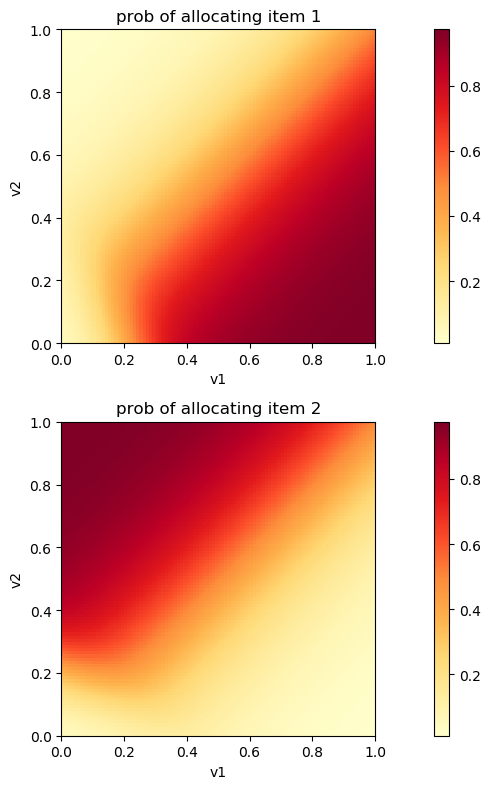

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
model.sinkhorn_rounds = 30
model.sinkhorn_epsilon = 5e-2
pu.plot_12_model(model.to(device='cpu'), 0.01, (2,3), (2,3))

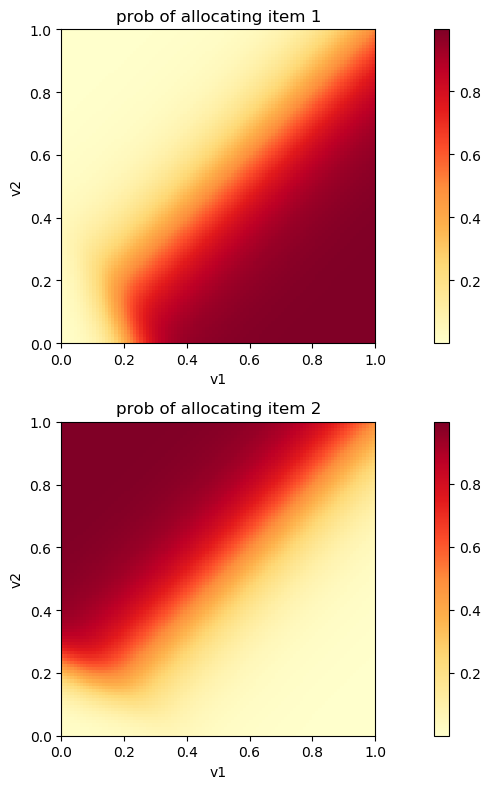

In [9]:
model.sinkhorn_rounds = 200
model.sinkhorn_epsilon = 3e-2
pu.plot_12_model(model.to(device='cpu'), 0.01, (2,3), (2,3))

In [10]:
def unit_1x2_2_3_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, 0, 1] + bids[i, 0, 0] < 2 * (4/3 + 1/3 * math.sqrt(4 + 3/2)):
            allocs[i, 0, :] = torch.tensor([0., 0.])
            payments[i, 0] = 0.
        elif abs(bids[i, 0, 0] - bids[i, 0, 1]) < 1 / 3:
            allocs[i, 0, :] = torch.tensor([.5, .5])
            payments[i, 0] =(4/3 + 1/3 * math.sqrt(4 + 3/2))
        elif bids[i, 0, 0] > 1/6 + 4/3 + 1/3 * math.sqrt(4 + 3/2):
            allocs[i, 0, :] = torch.tensor([1., 0.])
            payments[i, 0] = 1/6 + 4/3 + 1/3 * math.sqrt(4 + 3/2)
        else:
            allocs[i, 0, :] = torch.tensor([0., 1.])
            payments[i, 0] = 1/6 + 4/3 + 1/3 * math.sqrt(4 + 3/2)
    return allocs, payments

In [11]:
alloc, pay = unit_1x2_2_3_optimal_mechanism(test_data)
pay.mean()

tensor(2.1338)